# Plot model_complexity Vs training and validation loss

In [1]:
%tensorflow_version 1.14.0
from google.colab import drive
drive.mount("/content/gdrive")
%cd /content/gdrive/MyDrive/sunil/concepts_loss/concept_learning/

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14.0`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
Mounted at /content/gdrive
/content/gdrive/MyDrive/sunil/concepts_loss/concept_learning


In [4]:
# !git checkout .
# !git pull

In [5]:
# %cd clearn
# !git diff --name-only
# %cd ..

In [6]:
%matplotlib inline
import os
from copy import deepcopy
import pandas as pd
import numpy as np
from  scipy.signal import correlate2d
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import seaborn as sns

from clearn.config import ExperimentConfig
from clearn.analysis.plot_metrics import plot_epoch_vs_accuracy, plot_z_dim_vs_accuracy, plot_epoch_vs_metric, plot_hidden_units_accuracy_layerwise

In [7]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16
        }
matplotlib.rc('font', **font)

In [8]:
create_split = True
experiment_name = "find_architecture_unsupervised_vae_seg_mnist"
num_epochs = 50
run_id = 2
z_dim = 16
train_val_data_iterator = None
root_path="/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp"


In [9]:
from typing import Dict, List
from clearn.dao.dao_factory import get_dao
import logging
def plot_hidden_units_accuracy_layerwise(root_path: str,
                                         experiment_name: str,
                                         num_units: List[List[int]],
                                         num_cluster_config: str,
                                         z_dim: int,
                                         run_id: int,
                                         strides:List[int],
                                         num_dense_layers:int,
                                         dataset_types: List[str] = ["train", "test"],
                                         dataset="mnist",
                                         split_name="Split_1",
                                         batch_size=64,
                                         num_val_samples=128,
                                         num_decoder_layer=4,
                                         layer_num=0,
                                         fixed_layers=[],
                                         metric="accuracy",
                                         cumulative_function="max",
                                         fig_size=(20,8),
                                         fname=None,
                                         accuracies:Dict[int, List]=None,
                                         legend_lc="best",
                                         loglevel=logging.info
                                         ):
    if cumulative_function == "max":
        function_to_cumulate = np.max
        arg_function = np.argmax
    elif cumulative_function == "min":
        function_to_cumulate = np.min
        arg_function = np.argmin
    else:
        raise Exception("Argument cumulative function should be either min or max")
    dao = get_dao(dataset, split_name, num_val_samples, dataset_path=root_path+"/datasets/",)
    for dataset_name in dataset_types:
        plt.figure(figsize=fig_size)

        plt.xlabel("Hidden Units")
        plt.ylabel(f"Max {metric.capitalize()}({dataset_name})")
        accuracies = dict()
        num_epochs_trained = -1
        for num_unit in num_units:
            print(dataset_name, num_unit)
            if len(fixed_layers) > 0:
                skip_this = False
                for index, fixed_layer in enumerate(fixed_layers):
                    if num_unit[index] != fixed_layer:
                        skip_this = True
                        break
                if skip_this:
                    print(f"Skipping num_units {num_unit}")
                    continue
            exp_config = ExperimentConfig(root_path=root_path,
                                          num_decoder_layer=num_decoder_layer,
                                          z_dim=z_dim,
                                          num_units=num_unit,
                                          num_cluster_config=num_cluster_config,
                                          confidence_decay_factor=5,
                                          beta=5,
                                          supervise_weight=1,
                                          dataset_name=dataset,
                                          split_name=split_name,
                                          model_name="VAE",
                                          batch_size=batch_size,
                                          name=experiment_name,
                                          num_val_samples=num_val_samples,
                                          total_training_samples=dao.number_of_training_samples,
                                          manual_labels_config=ExperimentConfig.USE_CLUSTER_CENTER,
                                          reconstruction_weight=1,
                                          activation_hidden_layer="RELU",
                                          strides=strides,
                                          num_dense_layers=num_dense_layers
                                          )
            exp_config.check_and_create_directories(run_id, False)

            file_prefix = f"/{metric}*.csv"
            df = read_accuracy_from_file(exp_config.ANALYSIS_PATH + file_prefix)

            if df is not None:
                metric_col_name = f"{dataset_name}_{metric}_mean"
                if metric_col_name not in df.columns:
                    metric_col_name = f"{dataset_name}_{metric}"

                metric_values = df[metric_col_name].values
            else:
                # Try older version of accuracy file
                file_prefix = "/metrics_*.csv"
                if loglevel == logging.debug:
                    print("Reading from ",exp_config.ANALYSIS_PATH + file_prefix)
                df = read_accuracy_from_file(exp_config.ANALYSIS_PATH + file_prefix)
                if df is not None:
                    if f"{dataset_name}_{metric}_mean" in df.columns:
                        metric_values = df[f"{dataset_name}_{metric}_mean"].values
                    else:
                        metric_values = df[f"{dataset_name}_{metric}"].values


            if num_unit[layer_num] in accuracies:
                accuracies[num_unit[layer_num]].append([sum(num_unit[layer_num + 1:]),
                                                        float(function_to_cumulate( metric_values)),
                                                        int(arg_function(metric_values))
                                                        ]
                                                    )
            else:
                accuracies[num_unit[layer_num]] = [[sum(num_unit[layer_num + 1:]),
                                                    float(function_to_cumulate(metric_values)),
                                                    int(arg_function(metric_values))
                                                    ]
                                                ]
            _num_epochs_trained = df["epoch"].max() + 1
            if num_epochs_trained == -1:
                num_epochs_trained = _num_epochs_trained
            else:
                if _num_epochs_trained != num_epochs_trained:
                    print(f"Number of epochs for {num_unit} is {_num_epochs_trained}")

        for layer_0_units in accuracies.keys():
            x_y = np.asarray(accuracies[layer_0_units])
            sns.scatterplot(x_y[:, 0], x_y[:, 1], label=f"Units in layer {layer_num} {layer_0_units}", s=450)
            sns.lineplot(x_y[:, 0], x_y[:, 1])
        plt.legend(loc='lower right', shadow=True, fontsize='x-large')
        plt.title(f"Dataset:{dataset_name} Number of epochs trained {num_epochs_trained}. Fixed units ={fixed_layers}")
        if fname is not None:
            fname = exp_config.ANALYSIS_PATH + fname
            print(f"Saving plot in file {fname}")
            plt.savefig(fname, bbox="tight")

    plt.legend(loc=legend_lc, shadow=True, fontsize='x-large')
    plt.grid()
    return accuracies



In [10]:
import glob
def read_accuracy_from_file(file_prefix):
    df = None
    print(file_prefix)
    for file in glob.glob(file_prefix):
        print(file_prefix, file)
        temp_df = pd.read_csv(file)
        if df is None:
            df = temp_df
        else:
            df = pd.concat([df, temp_df], axis=0)
    return df


In [11]:
from typing import List
def plot_epoch_vs_accuracy(root_path: str,
                           experiment_name: str,
                           num_units: List[int],
                           num_cluster_config: str,
                           z_dim: int,
                           run_ids: List[int],
                           strides:List[int],
                           num_dense_layers:int,
                           dataset_types: List[str] = ["train", "test"],
                           activation_output_layer="SIGMOID",
                           dataset_name="mnist",
                           split_name="Split_1",
                           batch_size=64,
                           num_val_samples=-1,
                           num_decoder_layer=4,
                           metric="accuracy",
                           legend_loc="best",
                           exp_config=None,
                           confidence=False,
                           max_epoch=100,
                           max_accuracy=-1,
                           min_accuracy=0,
                           plot_filename=None
                           ):
    axis_font = {'fontname':'Arial', 'size':'26', "fontweight":"bold"}
    print("Num Units at the begining of function", num_units)

    if exp_config is None:
        dao = get_dao(dataset_name, split_name, num_val_samples)
        exp_config = ExperimentConfig(root_path=root_path,
                                      num_decoder_layer=num_decoder_layer,
                                      z_dim=z_dim,
                                      num_units=num_units,
                                      confidence_decay_factor=5,
                                      beta=5,
                                      supervise_weight=1,
                                      dataset_name=dataset_name,
                                      split_name=split_name,
                                      model_name="VAE",
                                      batch_size=batch_size,
                                      name=experiment_name,
                                      num_val_samples=num_val_samples,
                                      total_training_samples=dao.number_of_training_samples,
                                      manual_labels_config=ExperimentConfig.USE_CLUSTER_CENTER,
                                      reconstruction_weight=1,
                                      activation_hidden_layer="RELU",
                                      activation_output_layer=activation_output_layer,
                                      strides=strides,
                                      num_dense_layers=num_dense_layers,
                                      )
    # print("Num Units at the begining of function", exp_config.num_units, exp_config.ANALYSIS_PATH)


    file_prefix = f"/{metric}_*.csv"
    plt.figure(figsize=(16, 9))

    for run_id in run_ids:
        exp_config.check_and_create_directories(run_id)
        df = read_accuracy_from_file(exp_config.ANALYSIS_PATH + file_prefix)
        if df is not None:
            if loglevel == logging.debug:
                print("Shape of data read", df.shape)
            df = df[df["epoch"] < max_epoch]
            for dataset_name in dataset_types:
                print(dataset_name)
                if f"{dataset_name}_{metric}_mean" in df.columns:
                    metric_values = df[f"{dataset_name}_{metric}_mean"]
                else:
                    metric_values = df[f"{dataset_name}_{metric}"]
                plt.plot(df["epoch"], metric_values, label=f"{dataset_name}_{run_id}", lw=2)

        else:
            file_prefix = "/metrics_*.csv"
            print("Reading from metrics.csv")
            df = read_accuracy_from_file(exp_config.ANALYSIS_PATH + file_prefix)
            df = df[df["epoch"] < max_epoch]
            for dataset_type in dataset_types:
                if confidence:
                    metric_values = df[f"{dataset_type}_{metric}_std"].values
                else:
                    if f"{dataset_type}_{metric}_mean" in df.columns:
                        metric_values = df[f"{dataset_type}_{metric}_mean"].values
                    else:
                        metric_values = df[f"{dataset_type}_{metric}"].values

                plt.plot(df["epoch"], metric_values, label=f"{dataset_type}_{run_id}", lw=2)

    plt.xlabel("Epochs", **axis_font)
    plt.ylabel(metric.capitalize(), **axis_font)
    if max_accuracy != -1:
        plt.yticks(ticks = [i for i in range(min_accuracy, max_accuracy, max_accuracy // 10)],
                   labels=[i for i in range(min_accuracy, max_accuracy, max_accuracy // 10)],
                   **axis_font)
    plt.xticks(**axis_font)
    plt.legend(loc=legend_loc, shadow=True, fontsize='x-large')
    plt.title(f"Number of units {num_units}")
    plt.grid(axis="x")
    if plot_filename is not None:
        plt.savefig(os.path.join(exp_config.ANALYSIS_PATH + "/"+ plot_filename), bbox="tight")
    print("Plotting completed")
    return metric_values


# Experiment Parameters

In [12]:
num_units_list_5layer_512_256_0 = [[512, 256, 256, 128, 64],
                                 [512, 256, 256, 128, 32],
                                 [512, 256, 256, 64, 64],
                                 [512, 256, 256, 64, 32]
                                 ]
num_units_list_5layer_512_256_1 = [ [512, 256, 128, 128, 128],
                             [512, 256, 128, 128, 64],
                             [512, 256, 128, 128, 32],
                             [512, 256, 128, 64, 64],
                             [512, 256, 128, 64, 32],
                             [512, 256, 128, 32, 32],
                             [512, 256, 64, 64, 64],
                             [512, 256, 64, 64, 32],
                             [512, 256, 64, 32, 32],
                             [512, 256, 32, 32, 32],
                             ] 

num_units_list_5layer_512_256 = deepcopy(num_units_list_5layer_512_256_0)
num_units_list_5layer_512_256.extend(num_units_list_5layer_512_256_1)

num_units_list_5layer_512_512 = [[512, 512, 512, 512, 512],
                              [512, 512, 512, 512, 256],
                              [512, 512, 512, 512, 128],
                              [512, 512, 512, 512, 64],
                              [512, 512, 512, 512, 32],
                              [512, 512, 512, 256, 256],
                              [512, 512, 512, 256, 128],
                              [512, 512, 512, 256, 64],
                              [512, 512, 512, 256, 32],
                              [512, 512, 512, 128, 64],
                              [512, 512, 512, 128, 32],
                              [512, 256, 256, 64, 64],
                              [512, 256, 256, 64, 32],
                              [512, 256, 256, 32, 32]
                              ]
stride_4_layer = [2, 2, 2, 1, 1]

num_units_list_4layer_512 = [[512, 256, 256, 128],
                  [512, 256, 128, 64],
                  [512, 256, 64, 64],
                  [512, 128, 64, 64],
                  [512, 128, 64, 32],
                  [512, 128, 32, 32],
                  [512, 64, 32, 32],
                  [512, 32, 32, 32]
                  ]
num_units_list_4layer_256 = [
                  [256, 256, 128, 64],
                  [256, 256, 128, 32],
                  [256, 256, 64, 64],
                  [256, 256, 32, 32],
                  [256, 128, 128, 64],
                  [256, 128, 128, 32],
                  [256, 128, 64, 64],
                  [256, 128, 64, 32],
                  [256, 128, 32, 32],
                  [256, 64, 64, 64],
                  [256, 64, 64, 32],
                  [256, 64, 32, 32],
                  [256, 32, 32, 32]
]

num_units_list_6layer_512_512 = [[512, 512, 512, 512, 512, 32],
                             [512, 512, 512, 512, 256,32],
                             [512, 512, 512, 512, 128,32],
                             [512, 512, 512, 512, 64,32],
                             [512, 512, 512, 512, 32,32],
                             [512, 512, 512, 256, 256,32],
                             [512, 512, 512, 256, 128,32],
                             [512, 512, 512, 256, 64,32],
                             [512, 512, 512, 256, 32,32],
                             [512, 512, 512, 128, 64,32],
                             [512, 512, 512, 128, 32,32],
                             [512, 256, 256, 64, 64,32],
                             [512, 256, 256, 64, 32,32],
                             [512, 256, 256, 32, 32,32],
                  ]

num_units_list_6layer_256 = [[256, 256, 128, 128, 64, 32],
                                 [256, 256, 128, 128, 64,32],
                                 [256, 256, 128, 64, 64,32],
                                 [256, 128, 128, 64, 64,32],
                                 [256, 128, 64, 64, 64,32],
                                 [256, 128, 64, 64, 32,32]
]


In [13]:
len(num_units_list_5layer_512_256)

14

In [14]:
exp_config = ExperimentConfig(root_path=root_path,
                              num_decoder_layer=4,
                              num_cluster_config=None,
                              name=experiment_name,
                              z_dim=z_dim,
                              batch_size=512,
                              beta=5,
                              reconstruction_weight=1,
                              num_units=num_units_list_4layer_512[0],
                              save_reconstructed_images=True,
                              split_name="split_70_30",
                              dataset_name="mnist_concepts",
                              eval_interval_in_epochs=4,
                              model_save_interval=10,
                              num_val_samples=-1,
                              run_evaluation_during_training=True,
                              return_latent_vector=False,
                              write_predictions=True,
                              fully_convolutional = True,
                              num_concepts=28,
                              strides=stride_4_layer,
                              activation_output_layer = "SIGMOID",
                              num_dense_layers=0,
                              uncorrelated_features=False,
                              concept_id=18
                              )
exp_config.check_and_create_directories(run_id)


/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/ split_70_30 manually_generated_concepts.json
Reading concepts map from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets//mnist_concepts/split_70_30/manually_generated_concepts.json
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


True

In [15]:
exp_config.ANALYSIS_PATH

'/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsupervised_vae_seg_mnist/Exp_128_256_256_512_16_2/analysis/'

In [16]:
!ls /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsupervised_vae_seg_mnist

Exp_128_128_128_256_512_16_2	 Exp_32_64_128_256_512_16_2
Exp_128_256_256_512_16_2	 Exp_32_64_128_512_16_2
Exp_128_512_512_512_512_16_2	 Exp_32_64_128_512_512_512_16_2
Exp_256_256_512_512_512_16_2	 Exp_32_64_256_256_512_16_2
Exp_256_512_512_512_512_16_2	 Exp_32_64_64_128_128_256_16_2
Exp_32_128_128_256_512_16_2	 Exp_32_64_64_128_256_256_16_2
Exp_32_128_256_256_512_16_2	 Exp_32_64_64_256_256_512_16_2
Exp_32_32_128_256_512_16_2	 Exp_32_64_64_256_512_16_2
Exp_32_32_128_512_16_2		 Exp_32_64_64_64_128_256_16_2
Exp_32_32_128_512_512_512_16_2	 Exp_512_512_512_512_512_16_2
Exp_32_32_32_256_256_512_16_2	 Exp_64_128_128_256_512_16_2
Exp_32_32_32_256_512_16_2	 Exp_64_128_256_256_512_16_2
Exp_32_32_32_512_16_2		 Exp_64_128_256_512_16_2
Exp_32_32_64_256_256_512_16_2	 Exp_64_512_512_512_512_16_2
Exp_32_32_64_256_512_16_2	 Exp_64_64_128_256_512_16_2
Exp_32_32_64_512_16_2		 Exp_64_64_128_512_16_2
Exp_32_32_64_64_128_256_16_2	 Exp_64_64_256_256_512_16_2
Exp_32_512_512_512_512_16_2	 Exp_64_64_256_512_16_

Num Units at the begining of function [512, 256, 256, 128]
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsupervised_vae_seg_mnist/Exp_128_256_256_512_16_2/analysis//reconstruction_loss_*.csv
Reading from metrics.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsupervised_vae_seg_mnist/Exp_128_256_256_512_16_2/analysis//metrics_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsupervised_vae_seg_mnist/Exp_128_256_256_512_16_2/analysis//metrics_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsupervised_vae_seg_mnist/Exp_128_256_256_512_16_2/analysis/metrics_0.csv
Plotting completed


<Figure size 432x288 with 0 Axes>

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


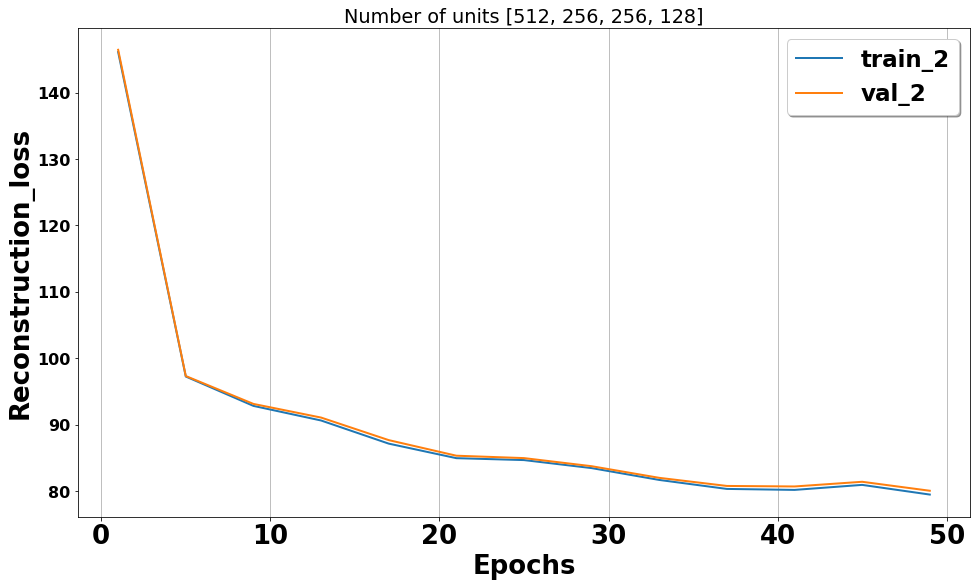

<Figure size 432x288 with 0 Axes>

In [17]:
run_id = 2
plot_epoch_vs_accuracy(root_path=exp_config.root_path,
                        experiment_name=exp_config.name,
                        num_units=exp_config.num_units,
                        z_dim=exp_config.Z_DIM,
                        run_ids=[run_id],
                        activation_output_layer="SIGMOID",
                        dataset_name=exp_config.dataset_name,
                        split_name=exp_config.split_name,
                        batch_size=exp_config.BATCH_SIZE,
                        num_val_samples=-exp_config.num_val_samples,
                        num_decoder_layer=exp_config.num_decoder_layer,
                        metric="reconstruction_loss",
                        strides=exp_config.strides,
                        num_dense_layers=exp_config.num_dense_layers,
                       num_cluster_config=exp_config.num_cluster_config,
                       dataset_types = ["train","val"],
                       exp_config=exp_config,
                       max_epoch=50
                      )
plt.figure()

# Scatter plot 5 layer

In [19]:
print(len(num_units_list_5layer_512_256))
print(len(num_units_list_5layer_512_512))
num_units_list_5layer = deepcopy(num_units_list_5layer_512_256)


14
14


## 512_512

In [ ]:
len(num_units_list_5layer_512_512)

14

In [ ]:
print(num_units_list_5layer_512_512)

[[512, 512, 512, 512, 512], [512, 512, 512, 512, 256], [512, 512, 512, 512, 128], [512, 512, 512, 512, 64], [512, 512, 512, 512, 32], [512, 512, 512, 256, 256], [512, 512, 512, 256, 128], [512, 512, 512, 256, 64], [512, 512, 512, 256, 32], [512, 512, 512, 128, 64], [512, 512, 512, 128, 32], [512, 256, 256, 64, 64], [512, 256, 256, 64, 32], [512, 256, 256, 32, 32]]


/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/ split_70_30 manually_generated_concepts.json
Reading concepts map from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets//mnist_concepts/split_70_30/manually_generated_concepts.json
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
val [512, 512, 512, 512, 512]
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/ split_70_30 manually_generated_concepts.json
Reading concepts map from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets//mnist_concepts/split_70_30/manually_generated_concepts.json
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsupervised_vae_seg_mnist/Exp_512_512_512_512_512_16_2/analysis//reconstruction_loss*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/conc

TypeError: ignored

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


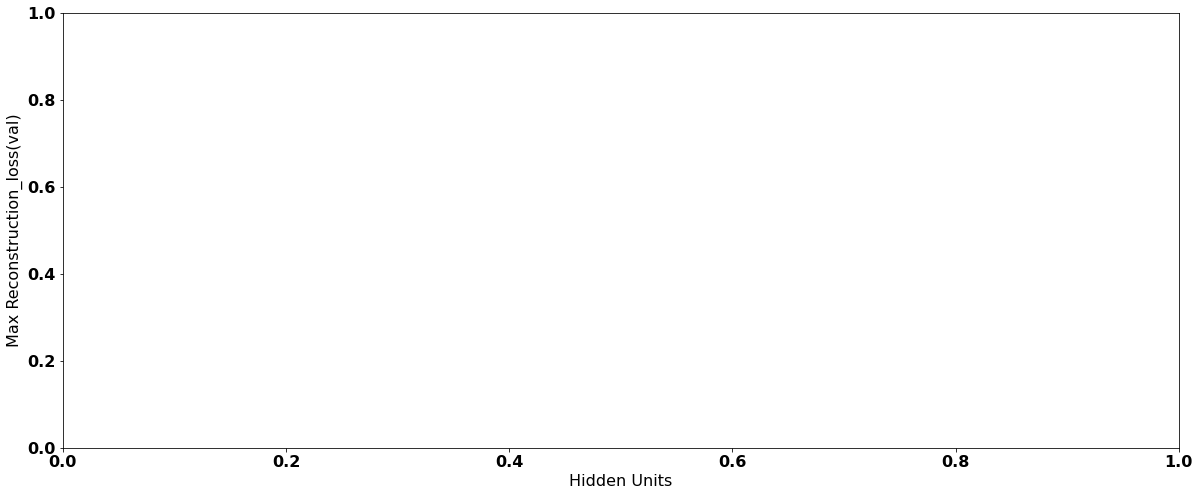

In [20]:
from copy import deepcopy
num_units_list_5_layer = deepcopy(num_units_list_5layer_512_512)

plot_hidden_units_accuracy_layerwise(root_path=exp_config.root_path,
                                     experiment_name= exp_config.name,
                                     num_units= num_units_list_5layer_512_512[0:5],
                                     num_cluster_config=exp_config.num_cluster_config,
                                     z_dim=exp_config.Z_DIM,
                                     run_id=2,
                                     strides=num_units_list_4layer_512,
                                         num_dense_layers=0,
                                         dataset_types =["val"],
                                         dataset="mnist_concepts",
                                         split_name="split_70_30",
                                         batch_size=512,
                                         num_val_samples=-1,
                                         num_decoder_layer=4,
                                         layer_num=0,
                                         fixed_layers=[],
                                         metric="reconstruction_loss",
                                         cumulative_function="min",
                                         fig_size=(20,8),
                                         fname=None,
                                         legend_lc="best"
                                         )

/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/ split_70_30 manually_generated_concepts.json
Reading concepts map from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets//mnist_concepts/split_70_30/manually_generated_concepts.json
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
[512, 512, 512, 512, 32]
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/ split_70_30 manually_generated_concepts.json
Reading concepts map from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets//mnist_concepts/split_70_30/manually_generated_concepts.json
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Num Units at the begining of function [512, 512, 512, 512, 32]
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsupervised_vae_seg_mnist/Exp_32_512_512_512_512_16_2/analysis//reconstruction_loss_*.csv
Read

TypeError: ignored

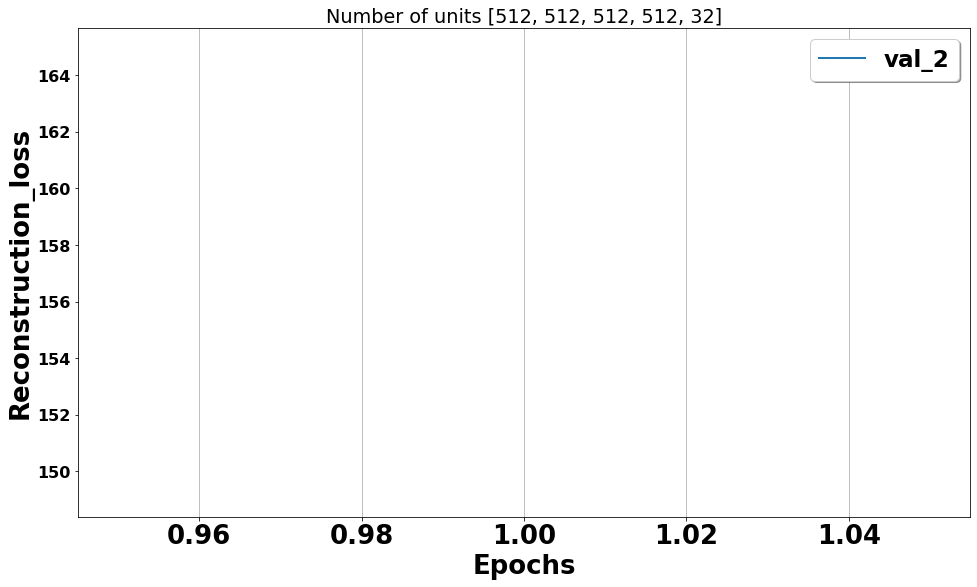

<Figure size 432x288 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

In [24]:
run_id=2
dao = get_dao("mnist_concepts", "split_70_30", -1, dataset_path=root_path+"/datasets/",)
strides = stride_4_layer
for num_units in num_units_list_5layer_512_512[4:]:
    print(num_units)
    exp_config = ExperimentConfig(root_path=root_path,
                                num_decoder_layer=5,
                                z_dim=z_dim,
                                num_units=num_units,
                                confidence_decay_factor=5,
                                beta=5,
                                supervise_weight=1,
                                dataset_name="mnist_concepts",
                                split_name="split_70_30",
                                model_name="VAE",
                                batch_size=512,
                                name=experiment_name,
                                num_val_samples=-1,
                                total_training_samples=dao.number_of_training_samples,
                                manual_labels_config=ExperimentConfig.USE_CLUSTER_CENTER,
                                reconstruction_weight=1,
                                activation_hidden_layer="RELU",
                                activation_output_layer="SIGMOID",
                                strides=strides,
                                num_dense_layers=0,
                                num_cluster_config=None
                                )
    plot_epoch_vs_accuracy(root_path=exp_config.root_path,
                            experiment_name=exp_config.name,
                            num_units=num_units,
                            z_dim=exp_config.Z_DIM,
                            run_ids=[run_id],
                            activation_output_layer="SIGMOID",
                            dataset_name=exp_config.dataset_name,
                            split_name=exp_config.split_name,
                            batch_size=exp_config.BATCH_SIZE,
                            num_val_samples=-exp_config.num_val_samples,
                            num_decoder_layer=exp_config.num_decoder_layer,
                            metric="reconstruction_loss",
                            strides=exp_config.strides,
                            num_dense_layers=exp_config.num_dense_layers,
                        num_cluster_config=exp_config.num_cluster_config,
                        dataset_types = ["val"],
                        exp_config=exp_config,
                        max_epoch=50
                        )
    plt.figure()

/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/ split_70_30 manually_generated_concepts.json
Reading concepts map from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets//mnist_concepts/split_70_30/manually_generated_concepts.json
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
val [512, 256, 256, 128, 64]
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/ split_70_30 manually_generated_concepts.json
Reading concepts map from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets//mnist_concepts/split_70_30/manually_generated_concepts.json
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsupervised_vae_seg_mnist/Exp_64_128_256_256_512_16_2/analysis//reconstruction_loss*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concep

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


{512: [[704, 79.05770874023438, 13],
  [672, 80.54354858398438, 13],
  [640, 81.65135955810547, 13],
  [608, 81.07109069824219, 12],
  [640, 81.33588409423828, 13],
  [576, 82.11678314208984, 13],
  [544, 80.25888061523438, 13],
  [512, 81.29595184326172, 13],
  [480, 82.69950866699219, 13],
  [448, 86.32473754882812, 7],
  [448, 82.86082458496094, 13],
  [416, 82.59812927246094, 13],
  [384, 84.8522720336914, 10],
  [2048, 78.07008361816406, 11],
  [1792, 80.45564270019531, 9],
  [1600, 77.82628631591797, 11]]}

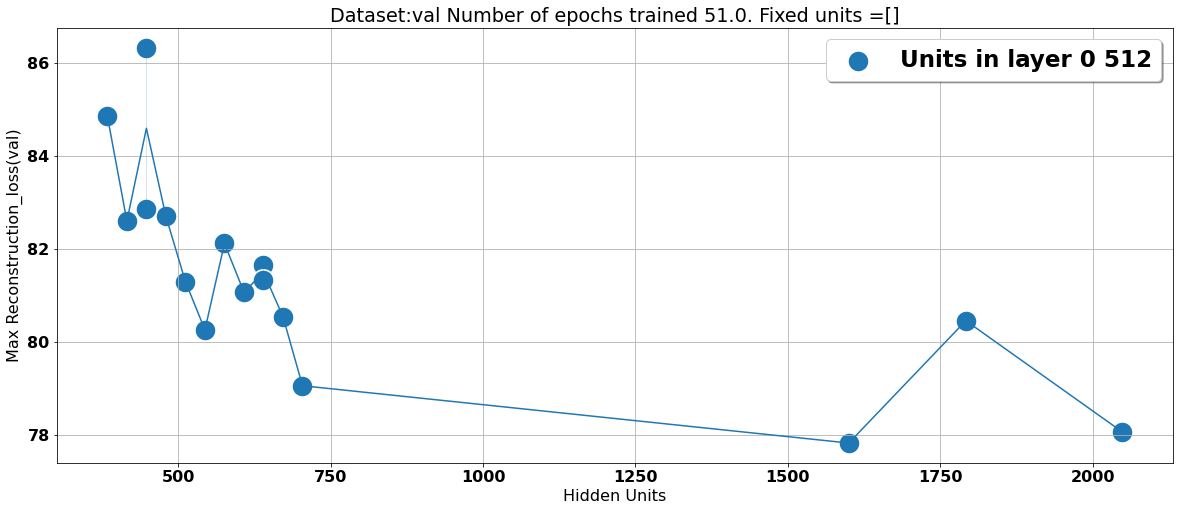

In [29]:
from copy import deepcopy
num_units_list_5_layer_512 = deepcopy(num_units_list_5layer_512_256[0:13])
num_units_list_5_layer_512.extend(num_units_list_5layer_512_512[0:2])

num_units_list_5_layer_512.append(num_units_list_5layer_512_512[3])
#num_units_list_5_layer_512.append(num_units_list_5layer_512_512[4])


plot_hidden_units_accuracy_layerwise(root_path=exp_config.root_path,
                                     experiment_name= exp_config.name,
                                     num_units= num_units_list_5_layer_512,
                                     num_cluster_config=exp_config.num_cluster_config,
                                     z_dim=exp_config.Z_DIM,
                                     run_id=2,
                                     strides=num_units_list_4layer_512,
                                         num_dense_layers=0,
                                         dataset_types =["val"],
                                         dataset="mnist_concepts",
                                         split_name="split_70_30",
                                         batch_size=512,
                                         num_val_samples=-1,
                                         num_decoder_layer=4,
                                         layer_num=0,
                                         fixed_layers=[],
                                         metric="reconstruction_loss",
                                         cumulative_function="min",
                                         fig_size=(20,8),
                                         fname=None,
                                         legend_lc="best"
                                         )

/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/ split_70_30 manually_generated_concepts.json
Reading concepts map from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets//mnist_concepts/split_70_30/manually_generated_concepts.json
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
val [512, 256, 256, 128, 64]
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/ split_70_30 manually_generated_concepts.json
Reading concepts map from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets//mnist_concepts/split_70_30/manually_generated_concepts.json
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsupervised_vae_seg_mnist/Exp_64_128_256_256_512_16_2/analysis//reconstruction_loss*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concep

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

{256: [[448, 79.05770874023438, 13],
  [416, 80.54354858398438, 13],
  [384, 81.65135955810547, 13],
  [352, 81.07109069824219, 12],
  [384, 81.33588409423828, 13],
  [320, 82.11678314208984, 13],
  [288, 80.25888061523438, 13],
  [256, 81.29595184326172, 13],
  [224, 82.69950866699219, 13],
  [192, 86.32473754882812, 7],
  [192, 82.86082458496094, 13],
  [160, 82.59812927246094, 13],
  [128, 84.8522720336914, 10]],
 512: [[1536, 78.07008361816406, 11],
  [1280, 80.45564270019531, 9],
  [1088, 77.82628631591797, 11]]}

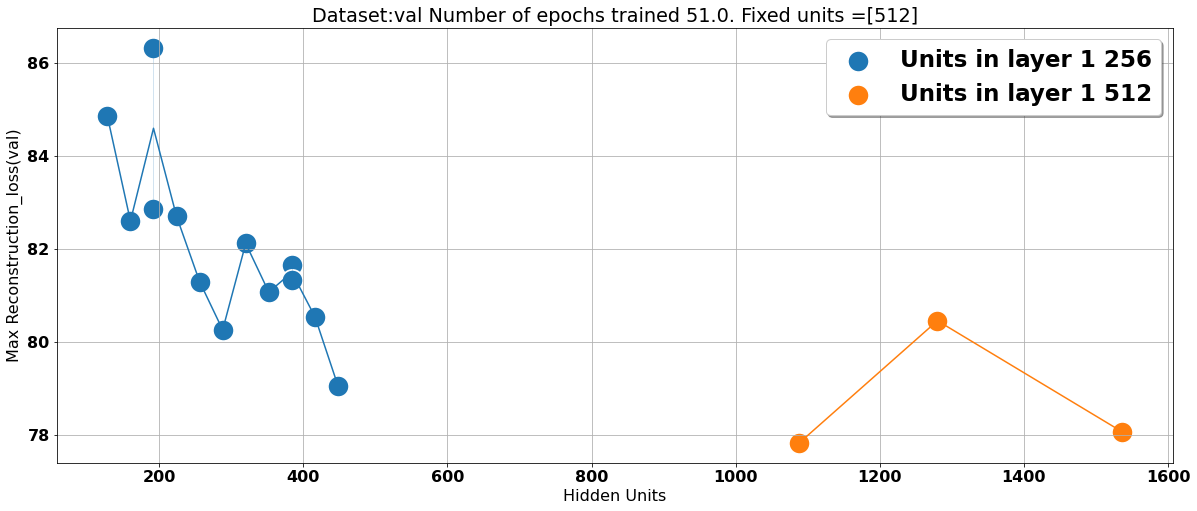

In [31]:
plot_hidden_units_accuracy_layerwise(root_path=exp_config.root_path,
                                     experiment_name= exp_config.name,
                                     num_units= num_units_list_5_layer_512,
                                     num_cluster_config=exp_config.num_cluster_config,
                                     z_dim=exp_config.Z_DIM,
                                     run_id=2,
                                     strides=num_units_list_4layer_512,
                                         num_dense_layers=0,
                                         dataset_types =["val"],
                                         dataset="mnist_concepts",
                                         split_name="split_70_30",
                                         batch_size=512,
                                         num_val_samples=-1,
                                         num_decoder_layer=4,
                                         layer_num=1,
                                         fixed_layers=[512],
                                         metric="reconstruction_loss",
                                         cumulative_function="min",
                                         fig_size=(20,8),
                                         fname=None,
                                         legend_lc="best"
                                         )

/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/ split_70_30 manually_generated_concepts.json
Reading concepts map from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets//mnist_concepts/split_70_30/manually_generated_concepts.json
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
val [512, 256, 256, 128, 64]
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/ split_70_30 manually_generated_concepts.json
Reading concepts map from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets//mnist_concepts/split_70_30/manually_generated_concepts.json
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsupervised_vae_seg_mnist/Exp_64_128_256_256_512_16_2/analysis//reconstruction_loss*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concep

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

{64: [[128, 82.86082458496094, 13],
  [96, 82.59812927246094, 13],
  [64, 84.8522720336914, 10]],
 128: [[256, 81.33588409423828, 13],
  [192, 82.11678314208984, 13],
  [160, 80.25888061523438, 13],
  [128, 81.29595184326172, 13],
  [96, 82.69950866699219, 13],
  [64, 86.32473754882812, 7]],
 256: [[192, 79.05770874023438, 13],
  [160, 80.54354858398438, 13],
  [128, 81.65135955810547, 13],
  [96, 81.07109069824219, 12]]}

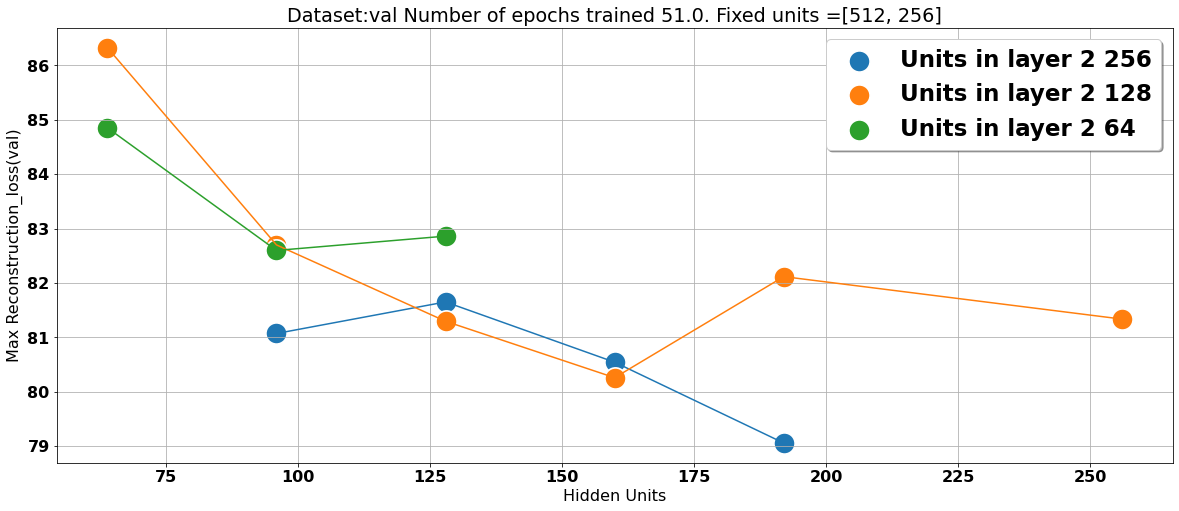

In [32]:
plot_hidden_units_accuracy_layerwise(root_path=exp_config.root_path,
                                     experiment_name= exp_config.name,
                                     num_units= num_units_list_5_layer_512,
                                     num_cluster_config=exp_config.num_cluster_config,
                                     z_dim=exp_config.Z_DIM,
                                     run_id=2,
                                     strides=num_units_list_4layer_512,
                                         num_dense_layers=0,
                                         dataset_types =["val"],
                                         dataset="mnist_concepts",
                                         split_name="split_70_30",
                                         batch_size=512,
                                         num_val_samples=-1,
                                         num_decoder_layer=4,
                                         layer_num=2,
                                         fixed_layers=[512, 256],
                                         metric="reconstruction_loss",
                                         cumulative_function="min",
                                         fig_size=(20,8),
                                         fname=None,
                                         legend_lc="best"
                                         )

In [36]:

for n in num_units_list_5layer_512_256:
  print(n)

[512, 256, 256, 128, 64]
[512, 256, 256, 128, 32]
[512, 256, 256, 64, 64]
[512, 256, 256, 64, 32]
[512, 256, 128, 128, 128]
[512, 256, 128, 128, 64]
[512, 256, 128, 128, 32]
[512, 256, 128, 64, 64]
[512, 256, 128, 64, 32]
[512, 256, 128, 32, 32]
[512, 256, 64, 64, 64]
[512, 256, 64, 64, 32]
[512, 256, 64, 32, 32]
[512, 256, 32, 32, 32]


/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/ split_70_30 manually_generated_concepts.json
Reading concepts map from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets//mnist_concepts/split_70_30/manually_generated_concepts.json
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
val [512, 256, 256, 128, 64]
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/ split_70_30 manually_generated_concepts.json
Reading concepts map from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets//mnist_concepts/split_70_30/manually_generated_concepts.json
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsupervised_vae_seg_mnist/Exp_64_128_256_256_512_16_2/analysis//reconstruction_loss*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concep

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

{64: [[64, 81.65135955810547, 13], [32, 81.07109069824219, 12]],
 128: [[64, 79.05770874023438, 13], [32, 80.54354858398438, 13]]}

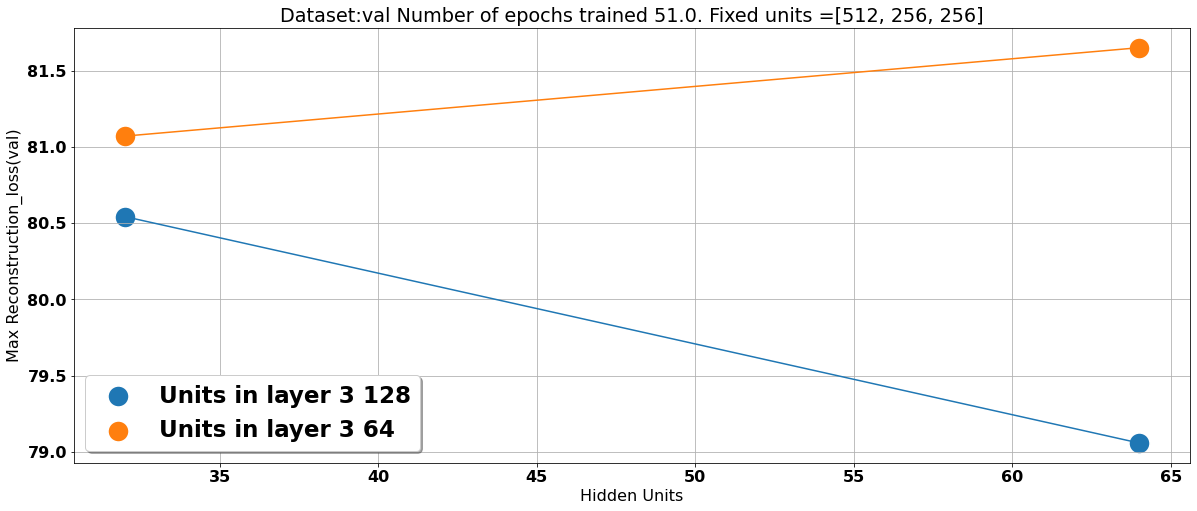

In [34]:
plot_hidden_units_accuracy_layerwise(root_path=exp_config.root_path,
                                     experiment_name= exp_config.name,
                                     num_units= num_units_list_5_layer_512,
                                     num_cluster_config=exp_config.num_cluster_config,
                                     z_dim=exp_config.Z_DIM,
                                     run_id=2,
                                     strides=num_units_list_4layer_512,
                                         num_dense_layers=0,
                                         dataset_types =["val"],
                                         dataset="mnist_concepts",
                                         split_name="split_70_30",
                                         batch_size=512,
                                         num_val_samples=-1,
                                         num_decoder_layer=4,
                                         layer_num=3,
                                         fixed_layers=[512,256,256],
                                         metric="reconstruction_loss",
                                         cumulative_function="min",
                                         fig_size=(20,8),
                                         fname=None,
                                         legend_lc="best"
                                         )

In [ ]:
print(len(num_units_list_5layer_512_512))

# Epoch Vs Reconstruction loss 5 layer

dataset_name mnist_concepts
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/ split_70_30 manually_generated_concepts.json
Reading concepts map from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets//mnist_concepts/split_70_30/manually_generated_concepts.json
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
[512, 256, 256, 128, 64]
dataset_name mnist_concepts
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/ split_70_30 manually_generated_concepts.json
Reading concepts map from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets//mnist_concepts/split_70_30/manually_generated_concepts.json
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Num Units at the begining of function [512, 256, 256, 128, 64]
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsupervised_vae_seg_mnist/Exp_64_128_2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Plotting completed
[512, 256, 64, 64, 32]
dataset_name mnist_concepts
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/ split_70_30 manually_generated_concepts.json
Reading concepts map from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets//mnist_concepts/split_70_30/manually_generated_concepts.json
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Num Units at the begining of function [512, 256, 64, 64, 32]
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsupervised_vae_seg_mnist/Exp_32_64_64_256_512_16_2/analysis//reconstruction_loss_*.csv
Reading from metrics.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsupervised_vae_seg_mnist/Exp_32_64_64_256_512_16_2/analysis//metrics_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsupervised_vae_seg_mnist/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Plotting completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


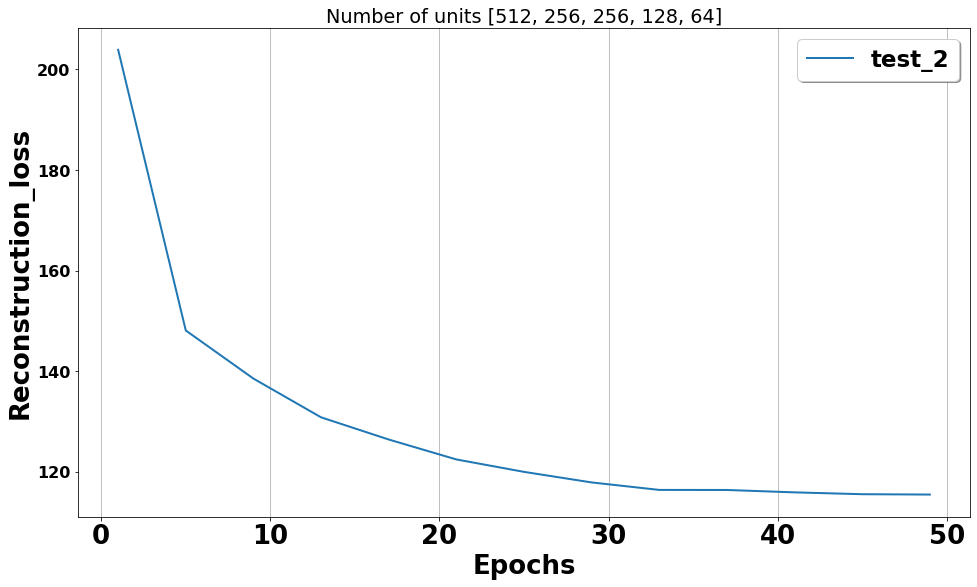

<Figure size 432x288 with 0 Axes>

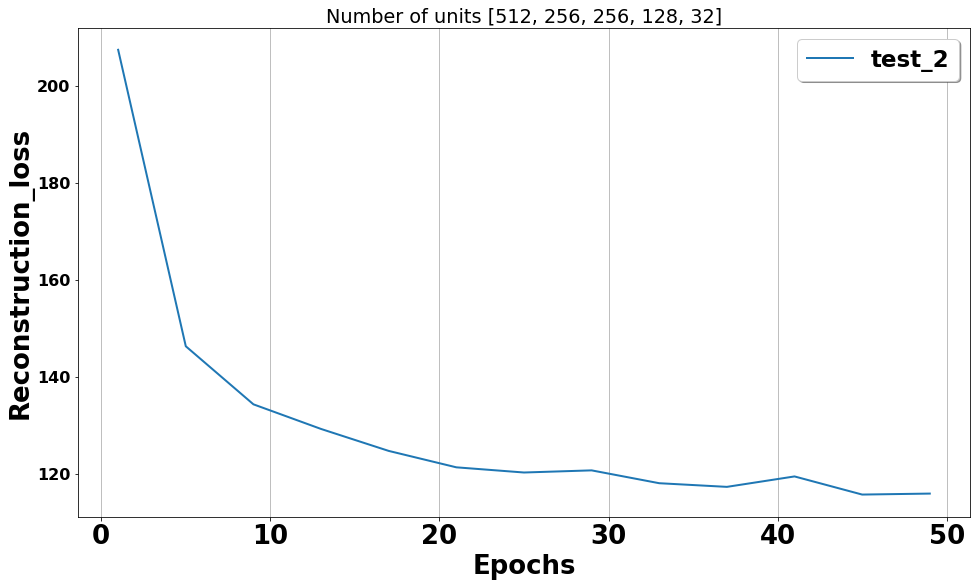

<Figure size 432x288 with 0 Axes>

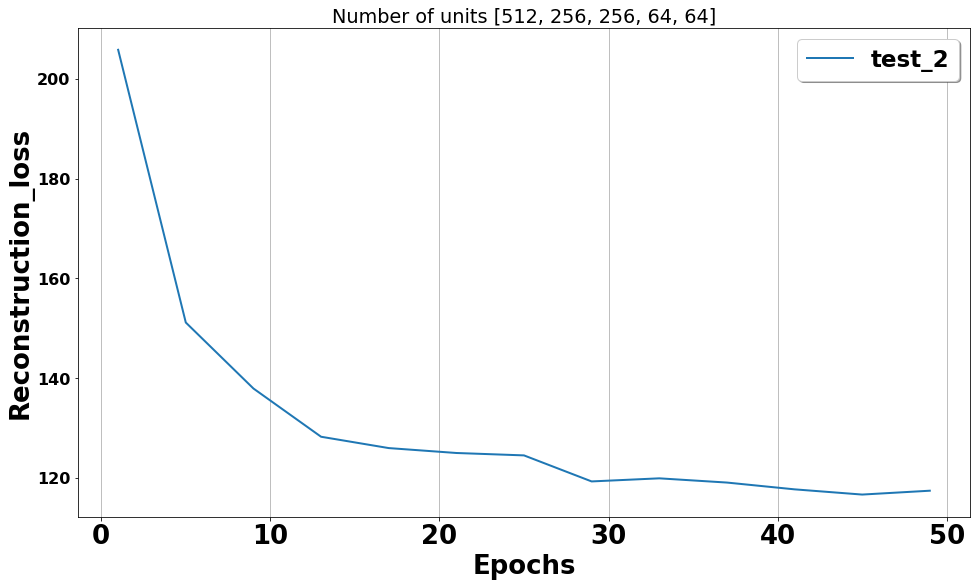

<Figure size 432x288 with 0 Axes>

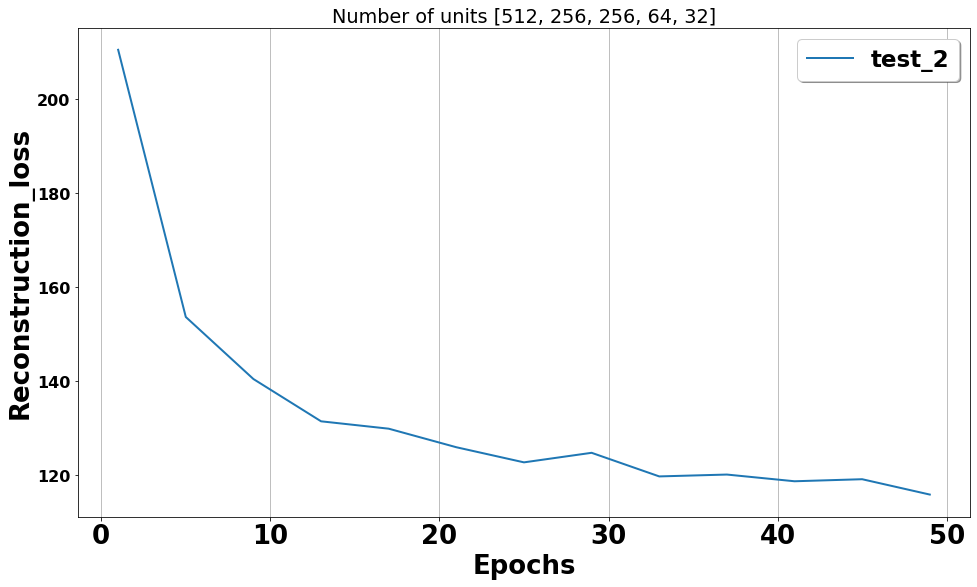

<Figure size 432x288 with 0 Axes>

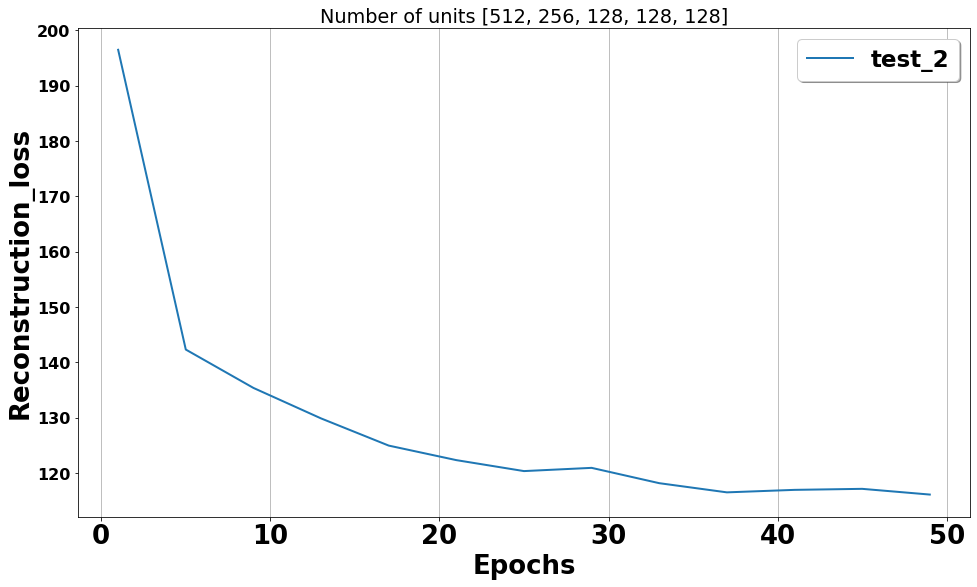

<Figure size 432x288 with 0 Axes>

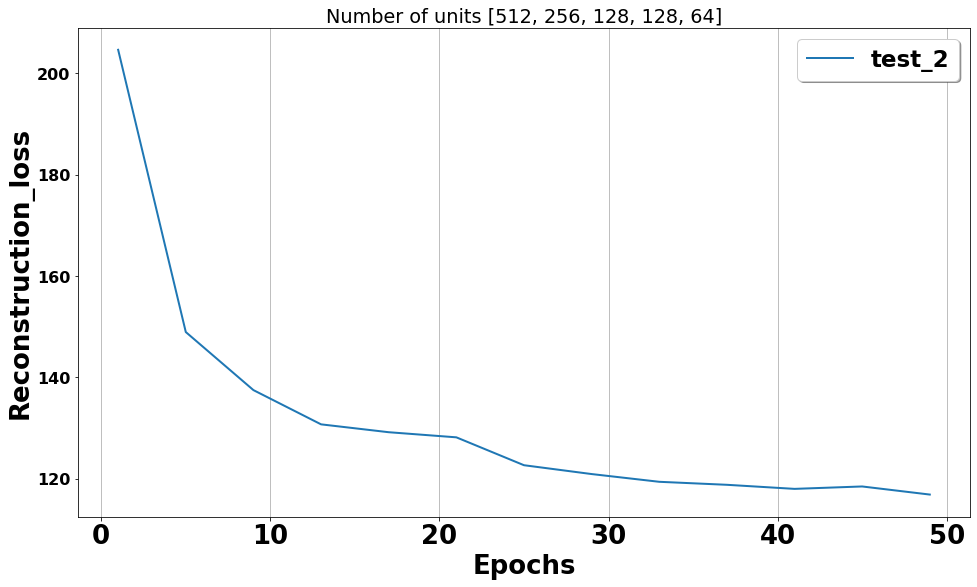

<Figure size 432x288 with 0 Axes>

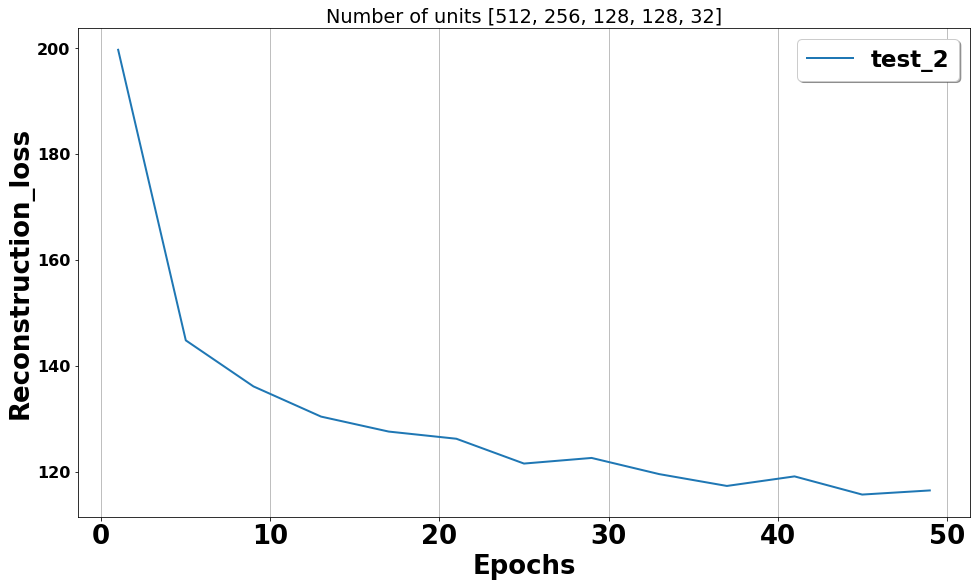

<Figure size 432x288 with 0 Axes>

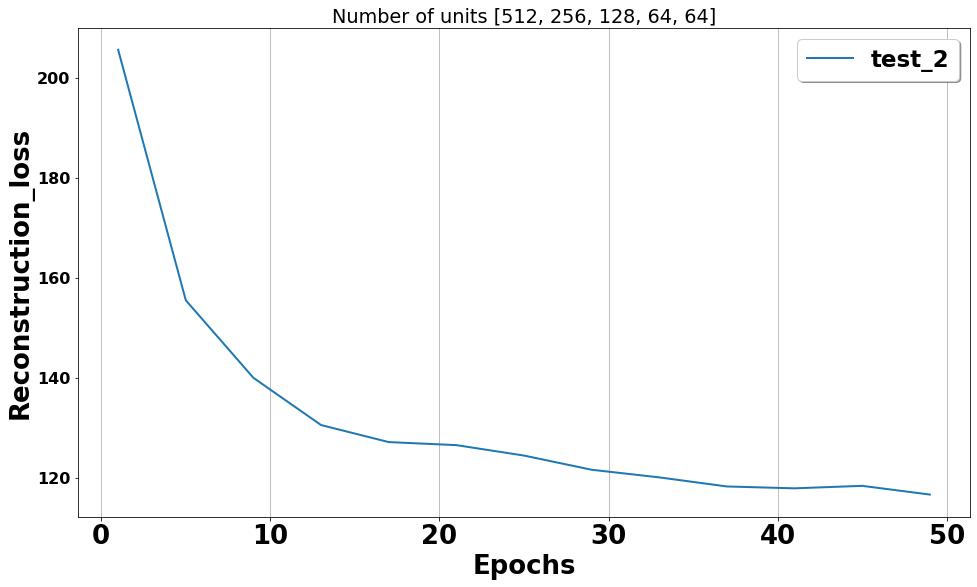

<Figure size 432x288 with 0 Axes>

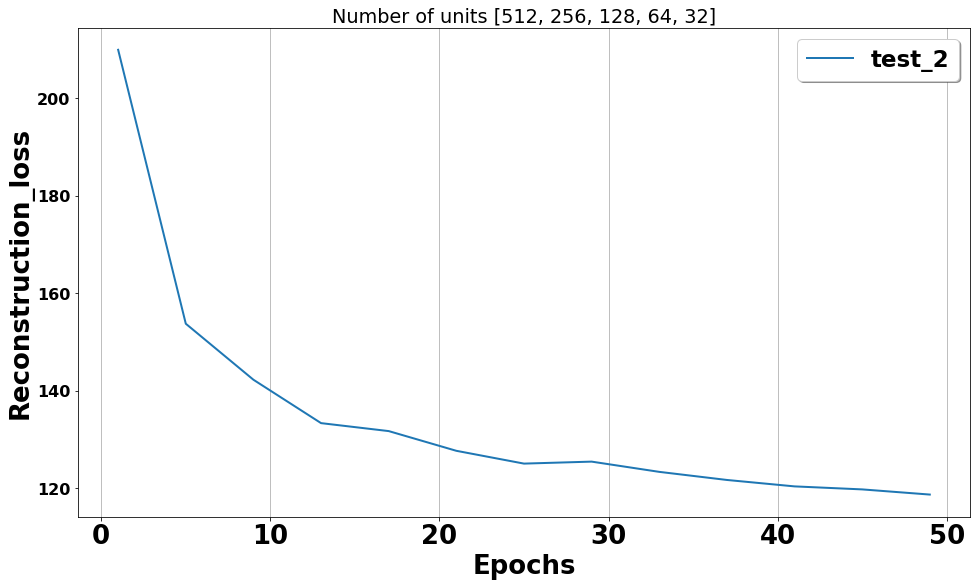

<Figure size 432x288 with 0 Axes>

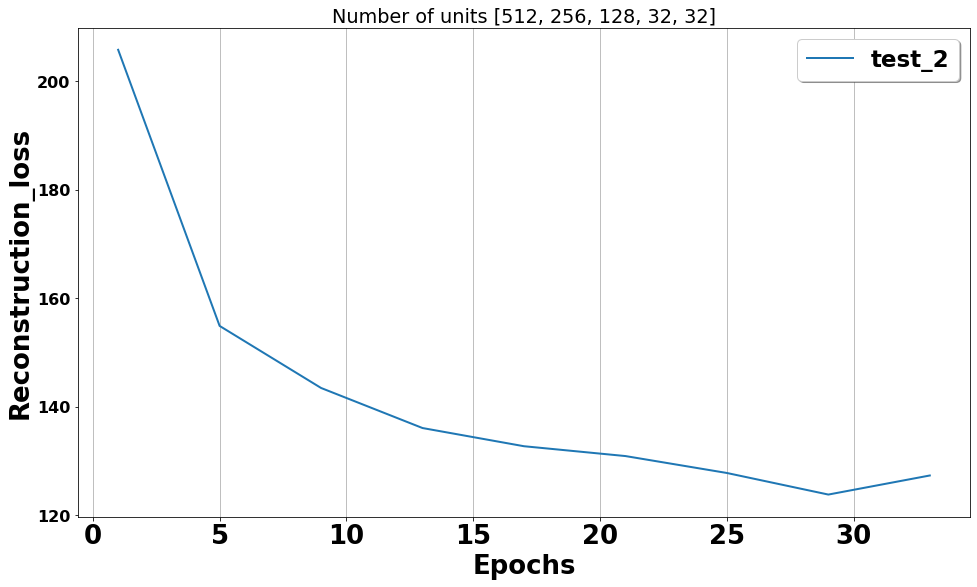

<Figure size 432x288 with 0 Axes>

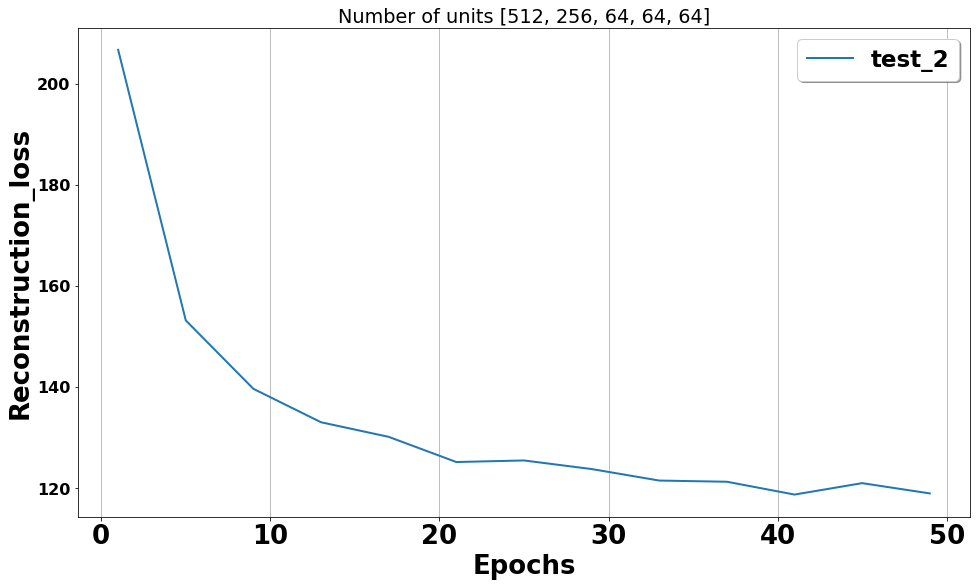

<Figure size 432x288 with 0 Axes>

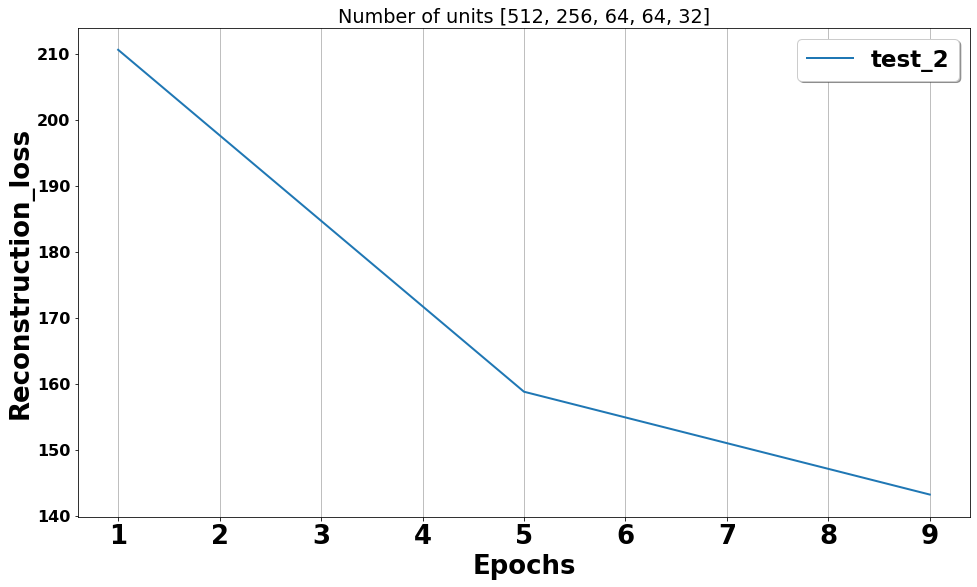

<Figure size 432x288 with 0 Axes>

In [ ]:
run_id=2
dao = get_dao("mnist_concepts", "split_70_30", -1, dataset_path=root_path+"/datasets/",)
strides = stride_4_layer
for num_units in num_units_list_5_layer_512[0:12]:
    print(num_units)
    exp_config = ExperimentConfig(root_path=root_path,
                                num_decoder_layer=5,
                                z_dim=z_dim,
                                num_units=num_units,
                                confidence_decay_factor=5,
                                beta=5,
                                supervise_weight=1,
                                dataset_name="mnist_concepts",
                                split_name="split_70_30",
                                model_name="VAE",
                                batch_size=512,
                                name=experiment_name,
                                num_val_samples=-1,
                                total_training_samples=dao.number_of_training_samples,
                                manual_labels_config=ExperimentConfig.USE_CLUSTER_CENTER,
                                reconstruction_weight=1,
                                activation_hidden_layer="RELU",
                                activation_output_layer="SIGMOID",
                                strides=strides,
                                num_dense_layers=0,
                                num_cluster_config=None
                                )
    plot_epoch_vs_accuracy(root_path=exp_config.root_path,
                            experiment_name=exp_config.name,
                            num_units=num_units,
                            z_dim=exp_config.Z_DIM,
                            run_ids=[run_id],
                            activation_output_layer="SIGMOID",
                            dataset_name=exp_config.dataset_name,
                            split_name=exp_config.split_name,
                            batch_size=exp_config.BATCH_SIZE,
                            num_val_samples=-exp_config.num_val_samples,
                            num_decoder_layer=exp_config.num_decoder_layer,
                            metric="reconstruction_loss",
                            strides=exp_config.strides,
                            num_dense_layers=exp_config.num_dense_layers,
                        num_cluster_config=exp_config.num_cluster_config,
                        dataset_types = ["test"],
                        exp_config=exp_config,
                        max_epoch=50
                        )
    plt.figure()

In [ ]:
print(num_units_list_5layer_512_256)

[[512, 256, 256, 128, 64], [512, 256, 256, 128, 32], [512, 256, 256, 64, 64], [512, 256, 256, 64, 32], [512, 256, 128, 128, 128], [512, 256, 128, 128, 64], [512, 256, 128, 128, 32], [512, 256, 128, 64, 64], [512, 256, 128, 64, 32], [512, 256, 128, 32, 32], [512, 256, 64, 64, 64], [512, 256, 64, 64, 32], [512, 256, 64, 32, 32], [512, 256, 32, 32, 32]]


# Scatter plot 5 layer 512 units in layer 0 256 in layer 1

> Indented block



dataset_name mnist_concepts
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/ split_70_30 manually_generated_concepts.json
Reading concepts map from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets//mnist_concepts/split_70_30/manually_generated_concepts.json
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
val [512, 256, 256, 128, 64]
dataset_name mnist_concepts
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/ split_70_30 manually_generated_concepts.json
Reading concepts map from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets//mnist_concepts/split_70_30/manually_generated_concepts.json
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsupervised_vae_seg_mnist/Exp_64_128_256_256_512_16_2/analysis//reconstruction_loss*.csv
/content

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


{512: [[704, 79.05770874023438, 13],
  [672, 80.54354858398438, 13],
  [640, 81.65135955810547, 13],
  [608, 81.07109069824219, 12],
  [640, 81.33588409423828, 13],
  [576, 82.11678314208984, 13],
  [544, 80.25888061523438, 13],
  [512, 81.29595184326172, 13],
  [480, 82.69950866699219, 13],
  [448, 86.32473754882812, 7],
  [448, 82.86082458496094, 13],
  [416, 82.59812927246094, 13],
  [384, 84.8522720336914, 10]]}

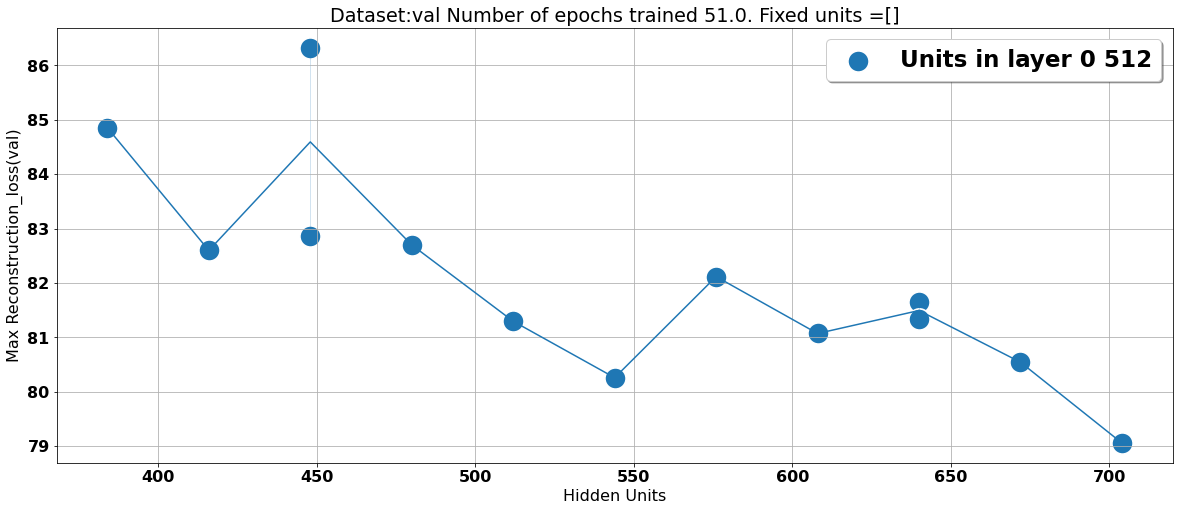

In [ ]:
plot_hidden_units_accuracy_layerwise(root_path=exp_config.root_path,
                                     experiment_name= exp_config.name,
                                     num_units= num_units_list_5layer_512_256[0:13],
                                         num_cluster_config=exp_config.num_cluster_config,
                                         z_dim=exp_config.Z_DIM,
                                         run_id=2,
                                         strides=num_units_list_4layer_512,
                                         num_dense_layers=0,
                                         dataset_types =["val"],
                                         dataset="mnist_concepts",
                                         split_name="split_70_30",
                                         batch_size=512,
                                         num_val_samples=-1,
                                         num_decoder_layer=4,
                                         layer_num=0,
                                         fixed_layers=[],
                                         metric="reconstruction_loss",
                                         cumulative_function="min",
                                         fig_size=(20,8),
                                         fname=None,
                                         legend_lc="best"
                                         )

In [ ]:
num_units_list_5layer_512_256[10]

[512, 256, 64, 64, 64]

In [ ]:
exp_config.ANALYSIS_PATH

'/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsupervised_vae_seg_mnist/Exp_32_64_128_512_512_512_16_2/analysis/'

In [ ]:
num_units_list_5layer_512_256[10]

[512, 256, 64, 64, 64]

dataset_name mnist_concepts
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/ split_70_30 manually_generated_concepts.json
Reading concepts map from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets//mnist_concepts/split_70_30/manually_generated_concepts.json
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
[512, 256, 64, 64, 64]
dataset_name mnist_concepts
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/ split_70_30 manually_generated_concepts.json
Reading concepts map from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets//mnist_concepts/split_70_30/manually_generated_concepts.json
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Num Units at the begining of function [512, 256, 64, 64, 64]
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsupervised_vae_seg_mnist/Exp_64_64_64_256

TypeError: ignored

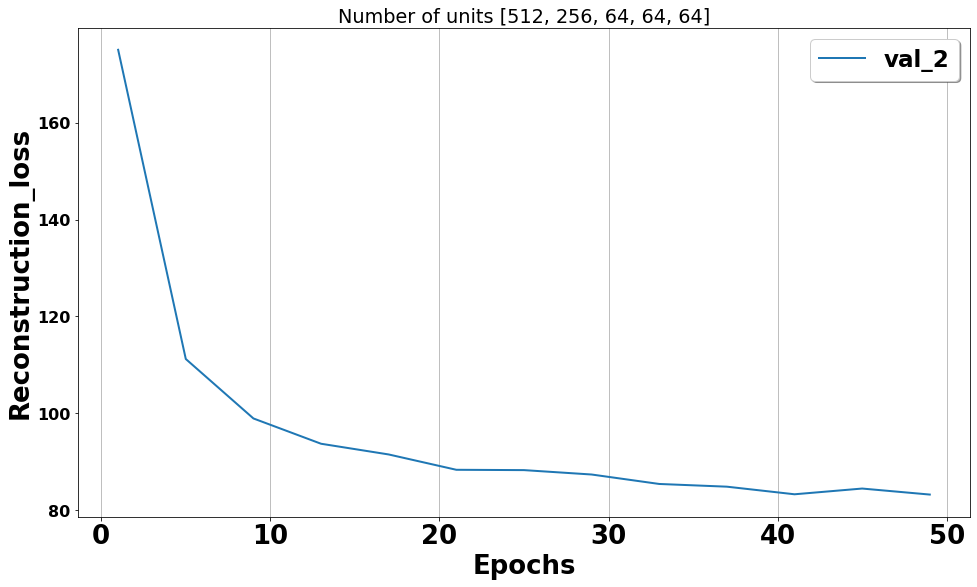

<Figure size 432x288 with 0 Axes>

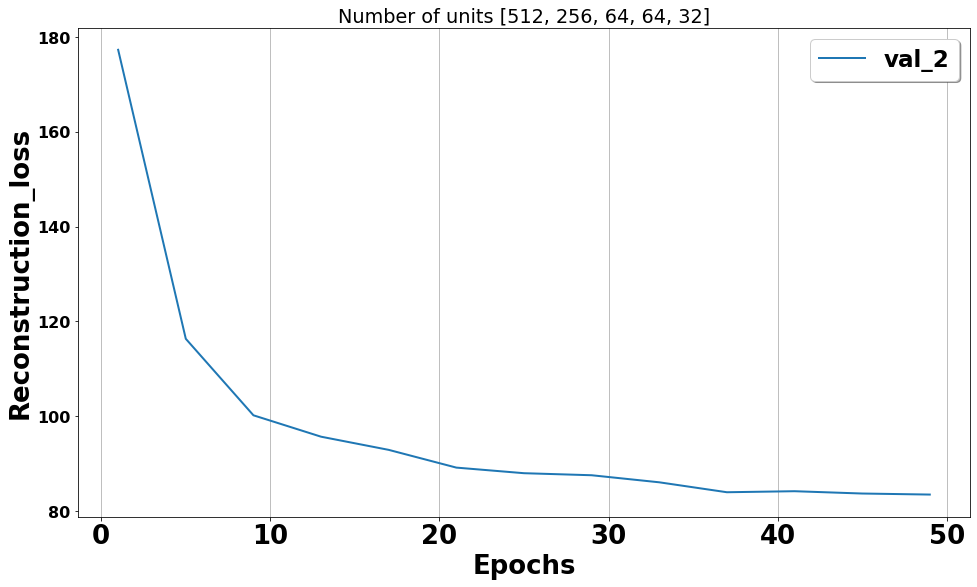

<Figure size 432x288 with 0 Axes>

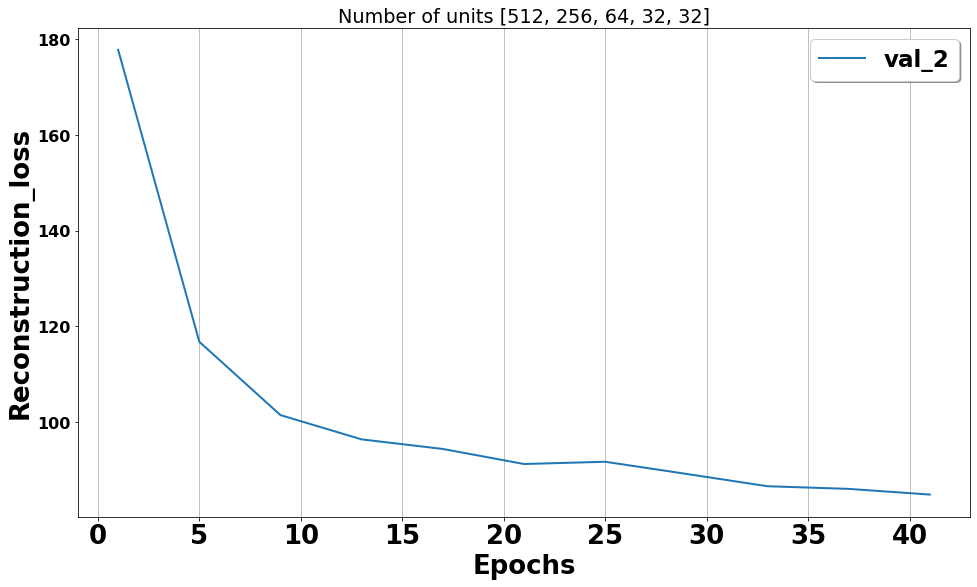

<Figure size 432x288 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

In [ ]:
run_id=2
dao = get_dao("mnist_concepts", "split_70_30", -1, dataset_path=root_path+"/datasets/",)
strides = stride_4_layer
for num_units in num_units_list_5layer_512_256[10:14]:
    print(num_units)
    exp_config = ExperimentConfig(root_path=root_path,
                                num_decoder_layer=5,
                                z_dim=z_dim,
                                num_units=num_units,
                                confidence_decay_factor=5,
                                beta=5,
                                supervise_weight=1,
                                dataset_name="mnist_concepts",
                                split_name="split_70_30",
                                model_name="VAE",
                                batch_size=512,
                                name=experiment_name,
                                num_val_samples=-1,
                                total_training_samples=dao.number_of_training_samples,
                                manual_labels_config=ExperimentConfig.USE_CLUSTER_CENTER,
                                reconstruction_weight=1,
                                activation_hidden_layer="RELU",
                                activation_output_layer="SIGMOID",
                                strides=strides,
                                num_dense_layers=0,
                                num_cluster_config=None
                                )
    plot_epoch_vs_accuracy(root_path=exp_config.root_path,
                            experiment_name=exp_config.name,
                            num_units=num_units,
                            z_dim=exp_config.Z_DIM,
                            run_ids=[run_id],
                            activation_output_layer="SIGMOID",
                            dataset_name=exp_config.dataset_name,
                            split_name=exp_config.split_name,
                            batch_size=exp_config.BATCH_SIZE,
                            num_val_samples=-exp_config.num_val_samples,
                            num_decoder_layer=exp_config.num_decoder_layer,
                            metric="reconstruction_loss",
                            strides=exp_config.strides,
                            num_dense_layers=exp_config.num_dense_layers,
                        num_cluster_config=exp_config.num_cluster_config,
                        dataset_types = ["val"],
                        exp_config=exp_config,
                        max_epoch=50
                        )
    plt.figure()

In [ ]:
!ls /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsupervised_vae_seg_mnist/Exp_64_64_64_256_512_16_2


analysis  config.json  logs  prediction_results  trained_models


In [ ]:
!ls /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsupervised_vae_seg_mnist/Exp_64_64_64_256_512_16_2/analysis

In [ ]:
#!rm -rf /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsupervised_vae_seg_mnist/Exp_64_64_64_256_512_16_2

# 6 Layer

In [ ]:
num_units_list_6layer = deepcopy(num_units_list_6layer_256)
num_units_list_6layer.extend(num_units_list_6layer_512_512_reversed[0:4])


dataset_name mnist_concepts
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/ split_70_30 manually_generated_concepts.json
Reading concepts map from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets//mnist_concepts/split_70_30/manually_generated_concepts.json
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
val [256, 256, 128, 128, 64, 32]
dataset_name mnist_concepts
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/ split_70_30 manually_generated_concepts.json
Reading concepts map from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets//mnist_concepts/split_70_30/manually_generated_concepts.json
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsupervised_vae_seg_mnist/Exp_32_64_128_128_256_256_16_2/analysis//reconstruction_loss*.csv
/

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

{256: [[608, 78.35295104980469, 13],
  [608, 78.35295104980469, 13],
  [544, 79.28736114501953, 13],
  [416, 79.1084213256836, 12],
  [352, 80.02254486083984, 13],
  [320, 81.62672424316406, 11]],
 512: [[608, 79.22555541992188, 12],
  [640, 77.93695068359375, 12],
  [672, 79.23799896240234, 12],
  [1216, 78.76409149169922, 8]]}

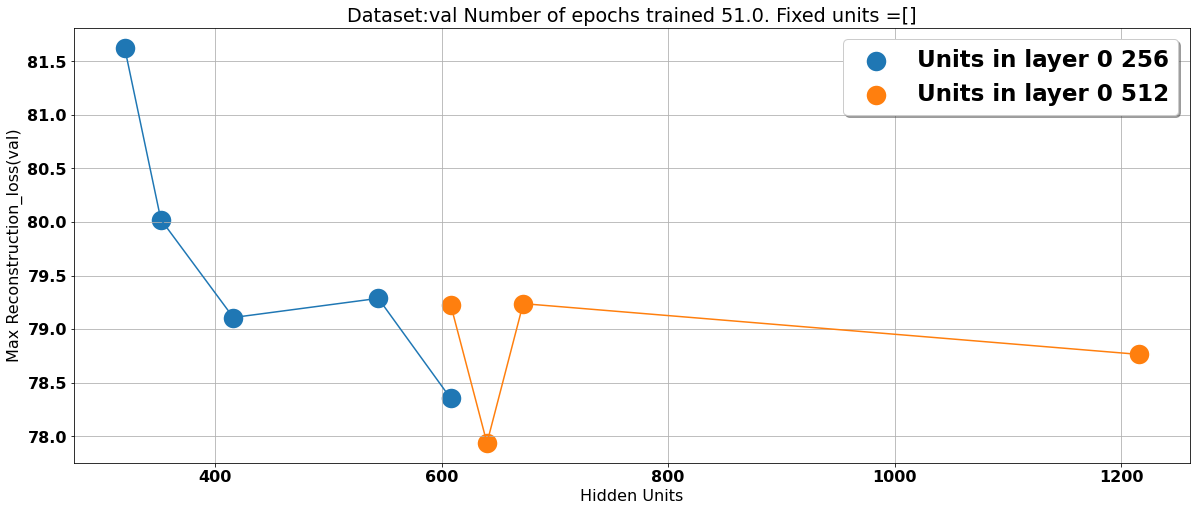

In [ ]:
strides_6_layer = [2,1,2,1,2,1,1]


plot_hidden_units_accuracy_layerwise(root_path=exp_config.root_path,
                                     experiment_name= exp_config.name,
                                     num_units= num_units_list_6layer,
                                         num_cluster_config=exp_config.num_cluster_config,
                                         z_dim=exp_config.Z_DIM,
                                         run_id=2,
                                         strides=num_units_list_4layer_512,
                                         num_dense_layers=0,
                                         dataset_types =["val"],
                                         dataset="mnist_concepts",
                                         split_name="split_70_30",
                                         batch_size=512,
                                         num_val_samples=-1,
                                         num_decoder_layer=4,
                                         layer_num=0,
                                         fixed_layers=[],
                                         metric="reconstruction_loss",
                                         cumulative_function="min",
                                         fig_size=(20,8),
                                         fname=None,
                                         legend_lc="best"
                                         )


dataset_name mnist_concepts
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/ split_70_30 manually_generated_concepts.json
Reading concepts map from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets//mnist_concepts/split_70_30/manually_generated_concepts.json
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
val [256, 256, 128, 128, 64, 32]
Skipping num_units [256, 256, 128, 128, 64, 32]
val [256, 256, 128, 128, 64, 32]
Skipping num_units [256, 256, 128, 128, 64, 32]
val [256, 256, 128, 64, 64, 32]
Skipping num_units [256, 256, 128, 64, 64, 32]
val [256, 128, 128, 64, 64, 32]
Skipping num_units [256, 128, 128, 64, 64, 32]
val [256, 128, 64, 64, 64, 32]
Skipping num_units [256, 128, 64, 64, 64, 32]
val [256, 128, 64, 64, 32, 32]
Skipping num_units [256, 128, 64, 64, 32, 32]
val [512, 256, 256, 32, 32, 32]
dataset_name mnist_concepts
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

{256: [[352, 79.22555541992188, 12],
  [384, 77.93695068359375, 12],
  [416, 79.23799896240234, 12]],
 512: [[704, 78.76409149169922, 8]]}

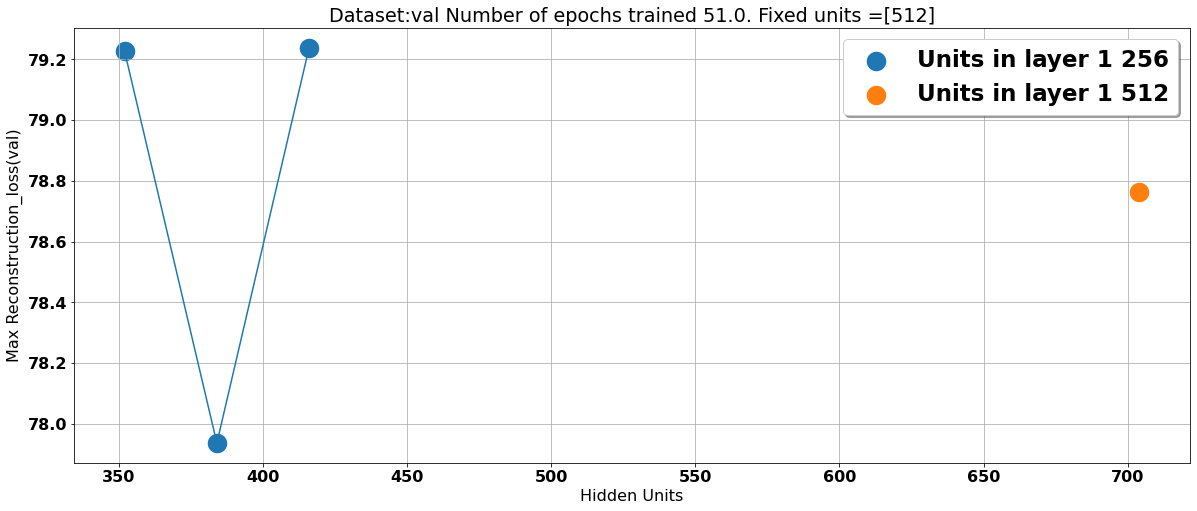

In [ ]:
strides_6_layer = [2,1,2,1,2,1,1]


plot_hidden_units_accuracy_layerwise(root_path=exp_config.root_path,
                                     experiment_name= exp_config.name,
                                     num_units= num_units_list_6layer,
                                         num_cluster_config=exp_config.num_cluster_config,
                                         z_dim=exp_config.Z_DIM,
                                         run_id=2,
                                         strides=num_units_list_4layer_512,
                                         num_dense_layers=0,
                                         dataset_types =["val"],
                                         dataset="mnist_concepts",
                                         split_name="split_70_30",
                                         batch_size=512,
                                         num_val_samples=-1,
                                         num_decoder_layer=4,
                                         layer_num=1,
                                         fixed_layers=[512],
                                         metric="reconstruction_loss",
                                         cumulative_function="min",
                                         fig_size=(20,8),
                                         fname=None,
                                         legend_lc="best"
                                         )


dataset_name mnist_concepts
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/ split_70_30 manually_generated_concepts.json
Reading concepts map from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets//mnist_concepts/split_70_30/manually_generated_concepts.json
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
val [256, 256, 128, 128, 64, 32]
Skipping num_units [256, 256, 128, 128, 64, 32]
val [256, 256, 128, 128, 64, 32]
Skipping num_units [256, 256, 128, 128, 64, 32]
val [256, 256, 128, 64, 64, 32]
Skipping num_units [256, 256, 128, 64, 64, 32]
val [256, 128, 128, 64, 64, 32]
Skipping num_units [256, 128, 128, 64, 64, 32]
val [256, 128, 64, 64, 64, 32]
Skipping num_units [256, 128, 64, 64, 64, 32]
val [256, 128, 64, 64, 32, 32]
Skipping num_units [256, 128, 64, 64, 32, 32]
val [512, 256, 256, 32, 32, 32]
dataset_name mnist_concepts
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


{256: [[96, 79.22555541992188, 12],
  [128, 77.93695068359375, 12],
  [160, 79.23799896240234, 12]]}

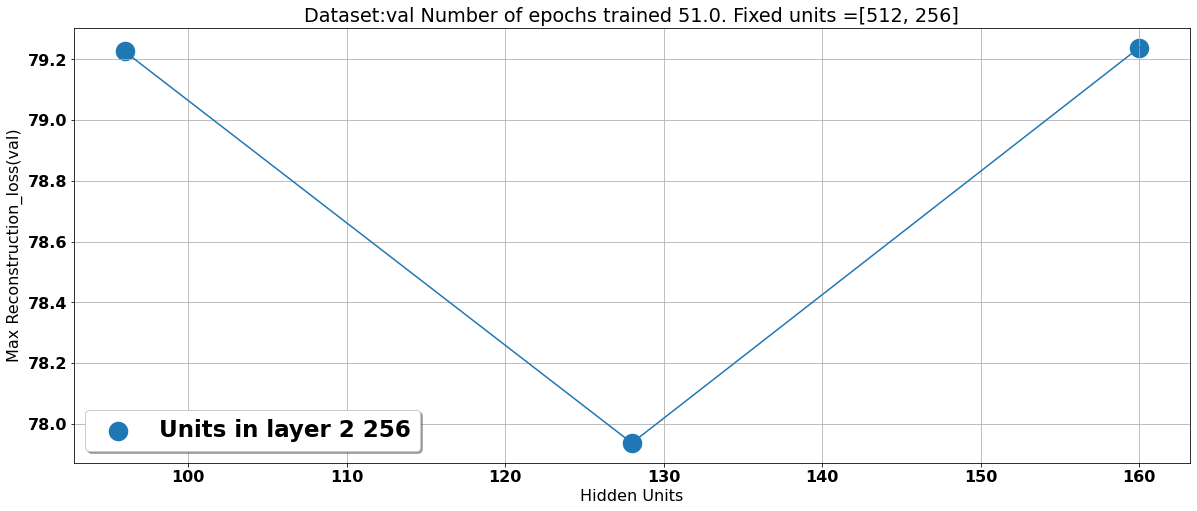

In [ ]:
strides_6_layer = [2,1,2,1,2,1,1]


plot_hidden_units_accuracy_layerwise(root_path=exp_config.root_path,
                                     experiment_name= exp_config.name,
                                     num_units= num_units_list_6layer,
                                         num_cluster_config=exp_config.num_cluster_config,
                                         z_dim=exp_config.Z_DIM,
                                         run_id=2,
                                         strides=num_units_list_4layer_512,
                                         num_dense_layers=0,
                                         dataset_types =["val"],
                                         dataset="mnist_concepts",
                                         split_name="split_70_30",
                                         batch_size=512,
                                         num_val_samples=-1,
                                         num_decoder_layer=4,
                                         layer_num=2,
                                         fixed_layers=[512, 256],
                                         metric="reconstruction_loss",
                                         cumulative_function="min",
                                         fig_size=(20,8),
                                         fname=None,
                                         legend_lc="best"
                                         )


#Scatter plot 6 layer 256 256

In [ ]:
num_units_list_6layer_256 = [[256, 256, 128, 128, 64, 32],
                                 [256, 256, 128, 128, 64,32],
                                 [256, 256, 128, 64, 64,32],
                                 [256, 128, 128, 64, 64,32],
                                 [256, 128, 64, 64, 64,32],
                                 [256, 128, 64, 64, 32,32]
]

dataset_name mnist_concepts
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/ split_70_30 manually_generated_concepts.json
Reading concepts map from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets//mnist_concepts/split_70_30/manually_generated_concepts.json
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
[256, 256, 128, 128, 64, 32]
dataset_name mnist_concepts
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/ split_70_30 manually_generated_concepts.json
Reading concepts map from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets//mnist_concepts/split_70_30/manually_generated_concepts.json
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Num Units at the begining of function [256, 256, 128, 128, 64, 32]
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsupervised_vae_seg_mnist/Exp_

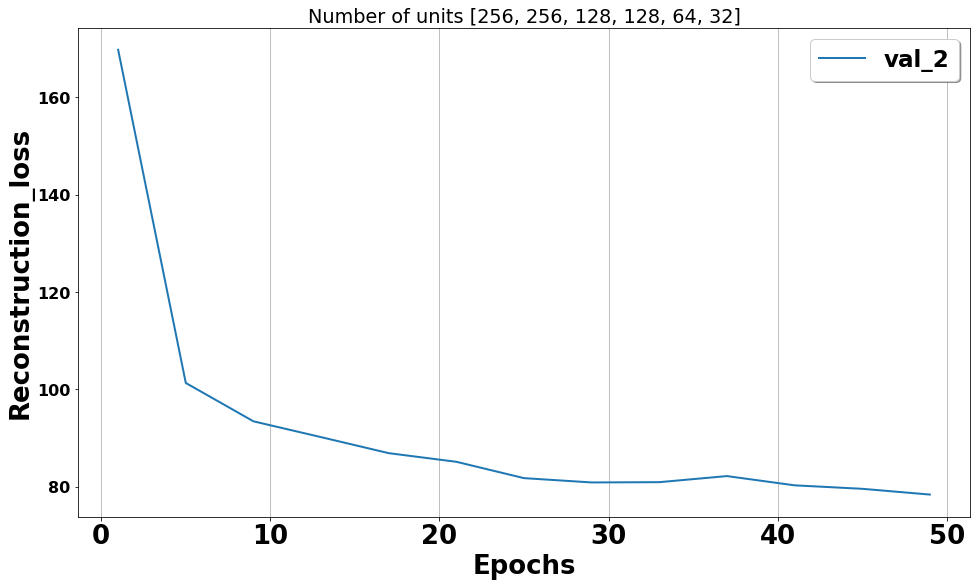

<Figure size 432x288 with 0 Axes>

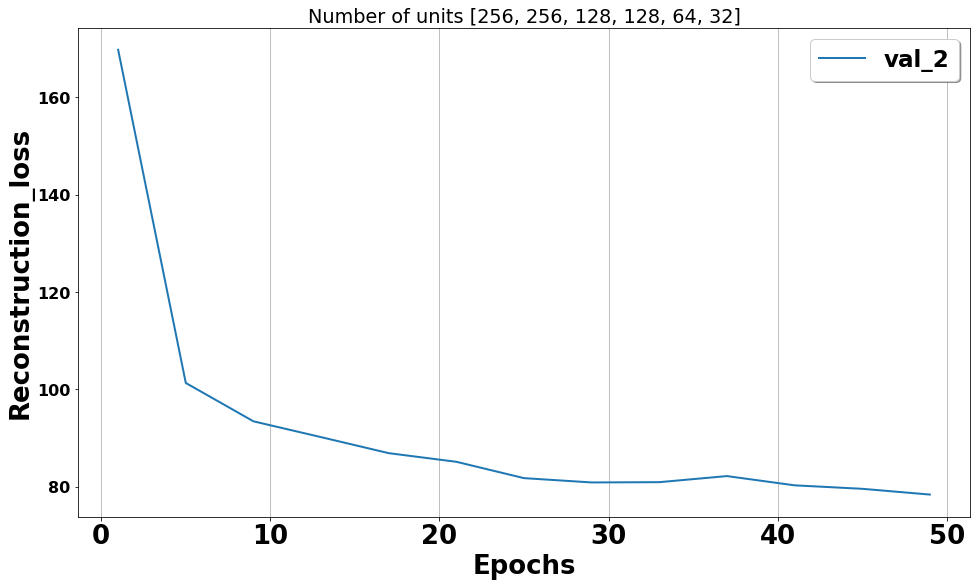

<Figure size 432x288 with 0 Axes>

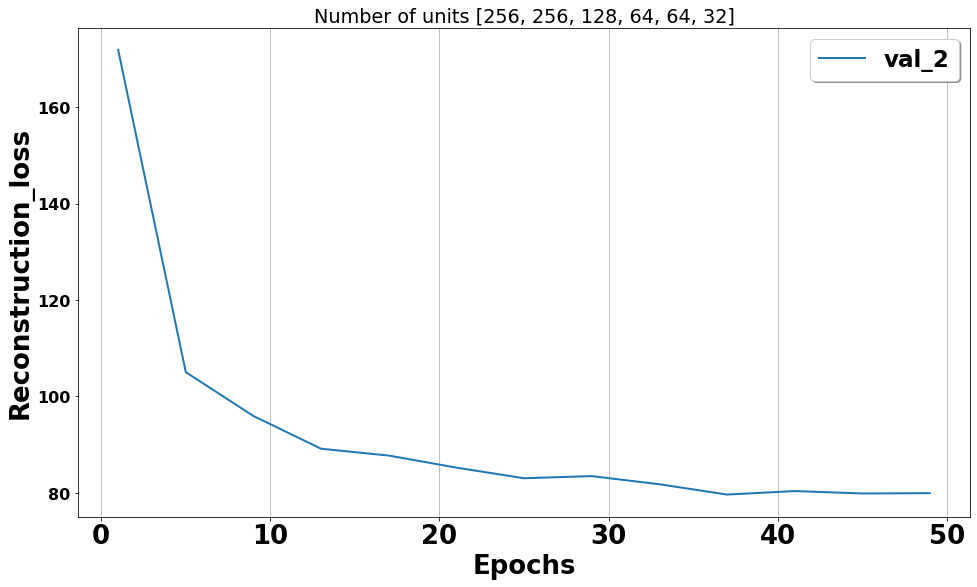

<Figure size 432x288 with 0 Axes>

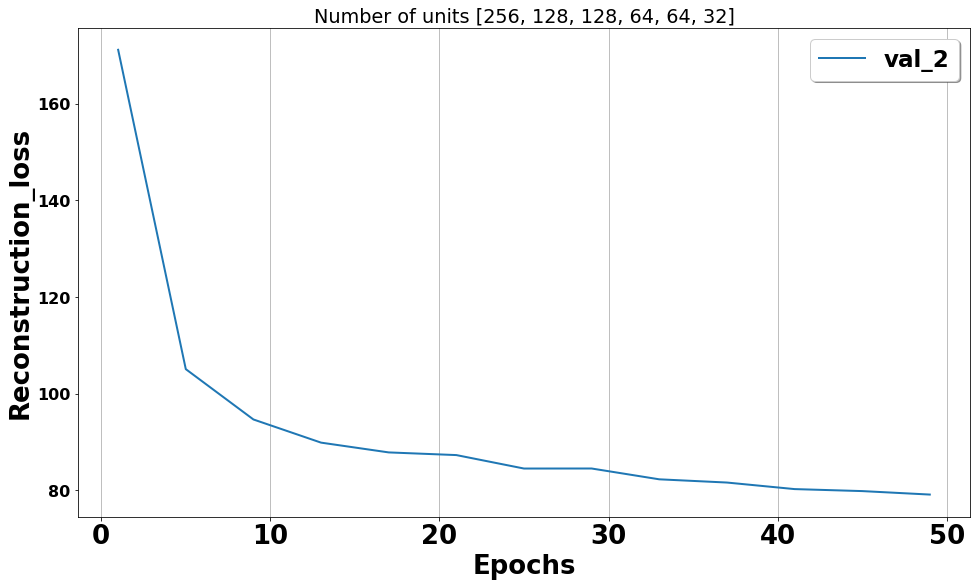

<Figure size 432x288 with 0 Axes>

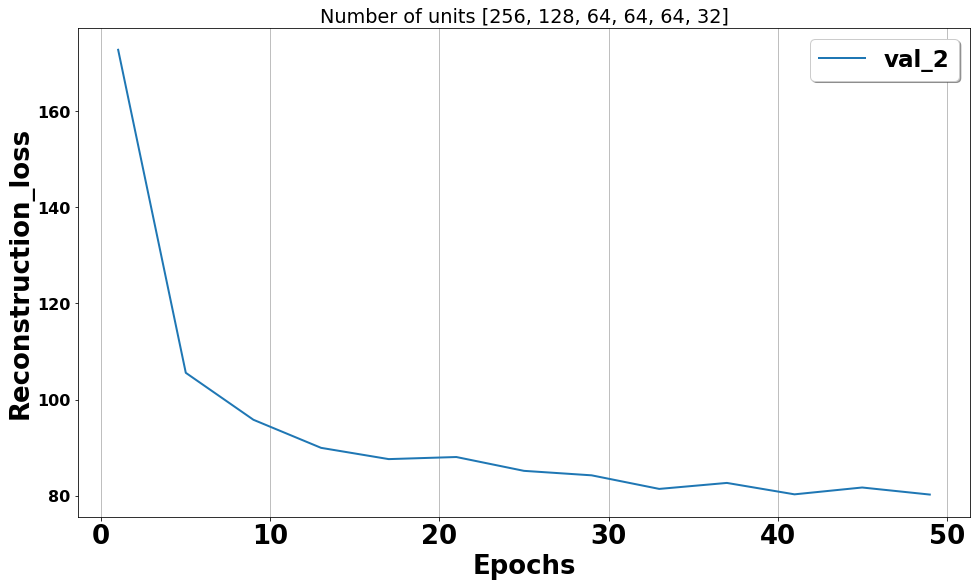

<Figure size 432x288 with 0 Axes>

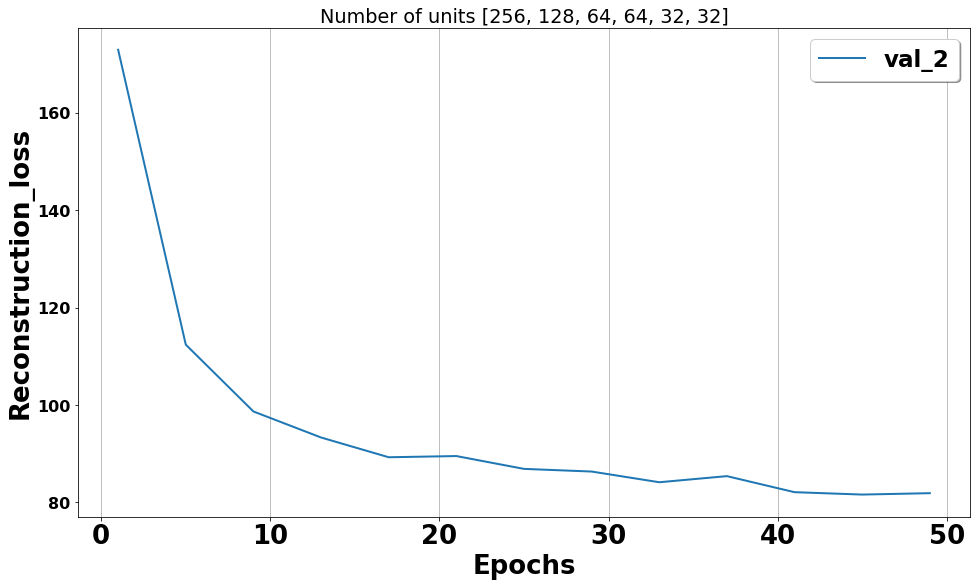

<Figure size 432x288 with 0 Axes>

In [ ]:
run_id=2
dao = get_dao("mnist_concepts", "split_70_30", -1, dataset_path=root_path+"/datasets/",)
strides = stride_4_layer
for num_units in num_units_list_6layer_256:
    print(num_units)
    exp_config = ExperimentConfig(root_path=root_path,
                                num_decoder_layer=5,
                                z_dim=z_dim,
                                num_units=num_units,
                                confidence_decay_factor=5,
                                beta=5,
                                supervise_weight=1,
                                dataset_name="mnist_concepts",
                                split_name="split_70_30",
                                model_name="VAE",
                                batch_size=512,
                                name=experiment_name,
                                num_val_samples=-1,
                                total_training_samples=dao.number_of_training_samples,
                                manual_labels_config=ExperimentConfig.USE_CLUSTER_CENTER,
                                reconstruction_weight=1,
                                activation_hidden_layer="RELU",
                                activation_output_layer="SIGMOID",
                                strides=strides,
                                num_dense_layers=0,
                                num_cluster_config=None
                                )
    plot_epoch_vs_accuracy(root_path=exp_config.root_path,
                            experiment_name=exp_config.name,
                            num_units=num_units,
                            z_dim=exp_config.Z_DIM,
                            run_ids=[run_id],
                            activation_output_layer="SIGMOID",
                            dataset_name=exp_config.dataset_name,
                            split_name=exp_config.split_name,
                            batch_size=exp_config.BATCH_SIZE,
                            num_val_samples=-exp_config.num_val_samples,
                            num_decoder_layer=exp_config.num_decoder_layer,
                            metric="reconstruction_loss",
                            strides=exp_config.strides,
                            num_dense_layers=exp_config.num_dense_layers,
                        num_cluster_config=exp_config.num_cluster_config,
                        dataset_types = ["val"],
                        exp_config=exp_config,
                        max_epoch=50
                        )
    plt.figure()

dataset_name mnist_concepts
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/ split_70_30 manually_generated_concepts.json
Reading concepts map from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets//mnist_concepts/split_70_30/manually_generated_concepts.json
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
val [256, 256, 128, 128, 64, 32]
dataset_name mnist_concepts
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/ split_70_30 manually_generated_concepts.json
Reading concepts map from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets//mnist_concepts/split_70_30/manually_generated_concepts.json
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsupervised_vae_seg_mnist/Exp_32_64_128_128_256_256_16_2/analysis//reconstruction_loss*.csv
/

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


{256: [[608, 78.35295104980469, 13],
  [608, 78.35295104980469, 13],
  [544, 79.28736114501953, 13],
  [416, 79.1084213256836, 12],
  [352, 80.02254486083984, 13],
  [320, 81.62672424316406, 11]]}

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


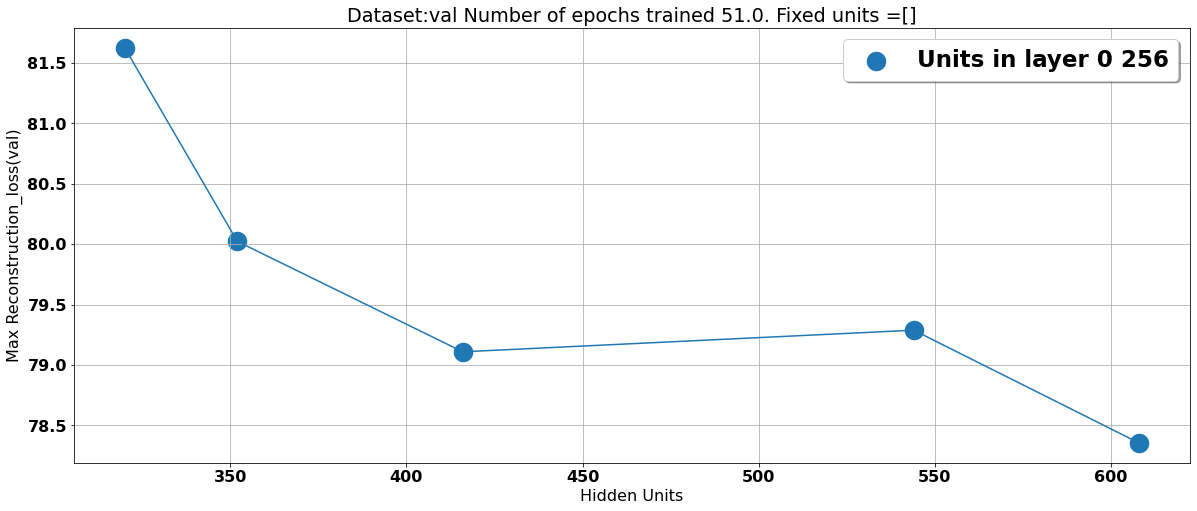

In [ ]:
strides_6_layer = [2,1,2,1,2,1,1]


plot_hidden_units_accuracy_layerwise(root_path=exp_config.root_path,
                                     experiment_name= exp_config.name,
                                     num_units= num_units_list_6layer_256,
                                         num_cluster_config=exp_config.num_cluster_config,
                                         z_dim=exp_config.Z_DIM,
                                         run_id=2,
                                         strides=num_units_list_4layer_512,
                                         num_dense_layers=0,
                                         dataset_types =["val"],
                                         dataset="mnist_concepts",
                                         split_name="split_70_30",
                                         batch_size=512,
                                         num_val_samples=-1,
                                         num_decoder_layer=4,
                                         layer_num=0,
                                         fixed_layers=[],
                                         metric="reconstruction_loss",
                                         cumulative_function="min",
                                         fig_size=(20,8),
                                         fname=None,
                                         legend_lc="best"
                                         )


dataset_name mnist_concepts
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/ split_70_30 manually_generated_concepts.json
Reading concepts map from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets//mnist_concepts/split_70_30/manually_generated_concepts.json
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
val [256, 256, 128, 128, 64, 32]
dataset_name mnist_concepts
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/ split_70_30 manually_generated_concepts.json
Reading concepts map from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets//mnist_concepts/split_70_30/manually_generated_concepts.json
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsupervised_vae_seg_mnist/Exp_32_64_128_128_256_256_16_2/analysis//reconstruction_loss*.csv
/

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

{128: [[288, 79.1084213256836, 12],
  [224, 80.02254486083984, 13],
  [192, 81.62672424316406, 11]],
 256: [[352, 78.35295104980469, 13],
  [352, 78.35295104980469, 13],
  [288, 79.28736114501953, 13]]}

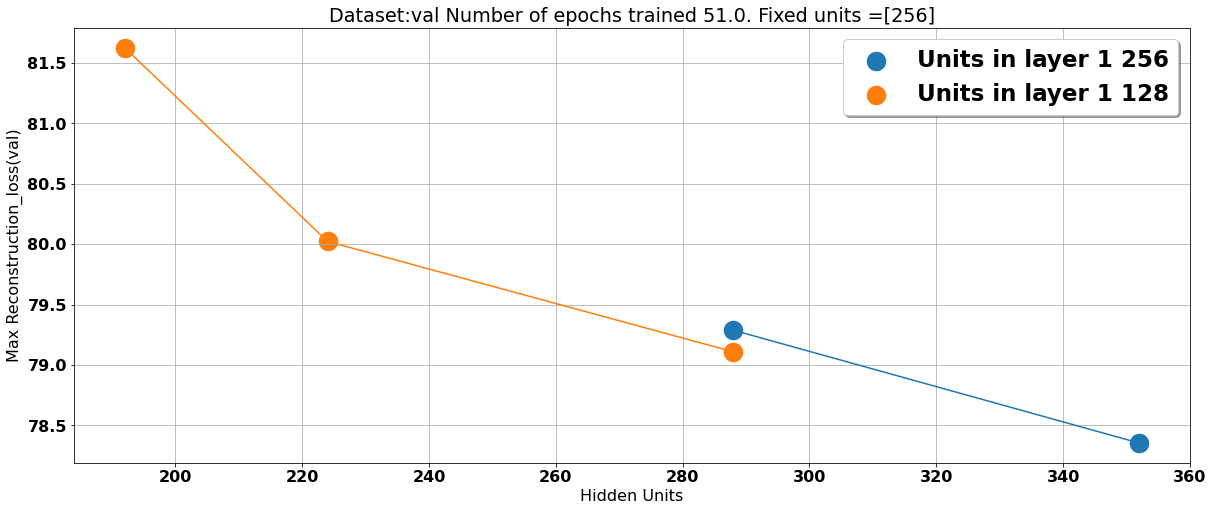

In [ ]:
strides_6_layer = [2,1,2,1,2,1,1]


plot_hidden_units_accuracy_layerwise(root_path=exp_config.root_path,
                                     experiment_name= exp_config.name,
                                     num_units= num_units_list_6layer_256,
                                         num_cluster_config=exp_config.num_cluster_config,
                                         z_dim=exp_config.Z_DIM,
                                         run_id=2,
                                         strides=num_units_list_4layer_512,
                                         num_dense_layers=0,
                                         dataset_types =["val"],
                                         dataset="mnist_concepts",
                                         split_name="split_70_30",
                                         batch_size=512,
                                         num_val_samples=-1,
                                         num_decoder_layer=4,
                                         layer_num=1,
                                         fixed_layers=[256],
                                         metric="reconstruction_loss",
                                         cumulative_function="min",
                                         fig_size=(20,8),
                                         fname=None,
                                         legend_lc="best"
                                         )


# Scatter plot 6 layer 512,512

In [ ]:
num_units_list_6layer_512_512_reversed = list(reversed(num_units_list_6layer_512_512))

dataset_name mnist_concepts
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/ split_70_30 manually_generated_concepts.json
Reading concepts map from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets//mnist_concepts/split_70_30/manually_generated_concepts.json
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
val [512, 256, 256, 32, 32, 32]
dataset_name mnist_concepts
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/ split_70_30 manually_generated_concepts.json
Reading concepts map from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets//mnist_concepts/split_70_30/manually_generated_concepts.json
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsupervised_vae_seg_mnist/Exp_32_32_32_256_256_512_16_2/analysis//reconstruction_loss*.csv
/co

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


{512: [[608, 79.22555541992188, 12],
  [640, 77.93695068359375, 12],
  [672, 79.23799896240234, 12],
  [1216, 78.76409149169922, 8]]}

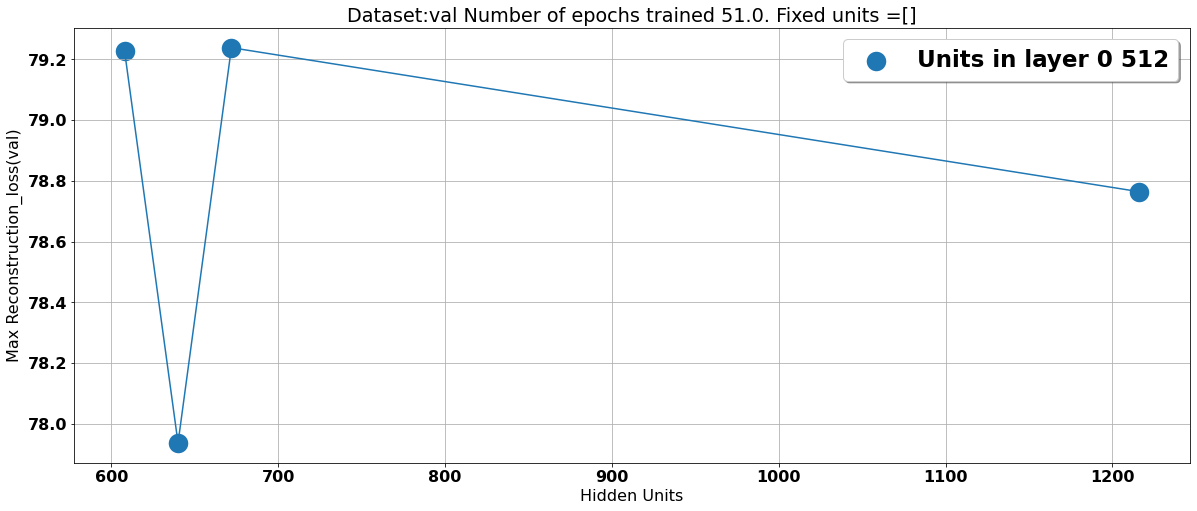

In [ ]:
strides_6_layer = [2,1,2,1,2,1,1]


plot_hidden_units_accuracy_layerwise(root_path=exp_config.root_path,
                                     experiment_name= exp_config.name,
                                     num_units= num_units_list_6layer_512_512_reversed[0:4],
                                         num_cluster_config=exp_config.num_cluster_config,
                                         z_dim=exp_config.Z_DIM,
                                         run_id=2,
                                         strides=num_units_list_4layer_512,
                                         num_dense_layers=0,
                                         dataset_types =["val"],
                                         dataset="mnist_concepts",
                                         split_name="split_70_30",
                                         batch_size=512,
                                         num_val_samples=-1,
                                         num_decoder_layer=4,
                                         layer_num=0,
                                         fixed_layers=[],
                                         metric="reconstruction_loss",
                                         cumulative_function="min",
                                         fig_size=(20,8),
                                         fname=None,
                                         legend_lc="best"
                                         )


dataset_name mnist_concepts
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/ split_70_30 manually_generated_concepts.json
Reading concepts map from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets//mnist_concepts/split_70_30/manually_generated_concepts.json
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
[512, 256, 256, 32, 32, 32]
dataset_name mnist_concepts
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/ split_70_30 manually_generated_concepts.json
Reading concepts map from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets//mnist_concepts/split_70_30/manually_generated_concepts.json
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Num Units at the begining of function [512, 256, 256, 32, 32, 32]
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsupervised_vae_seg_mnist/Exp_32

TypeError: ignored

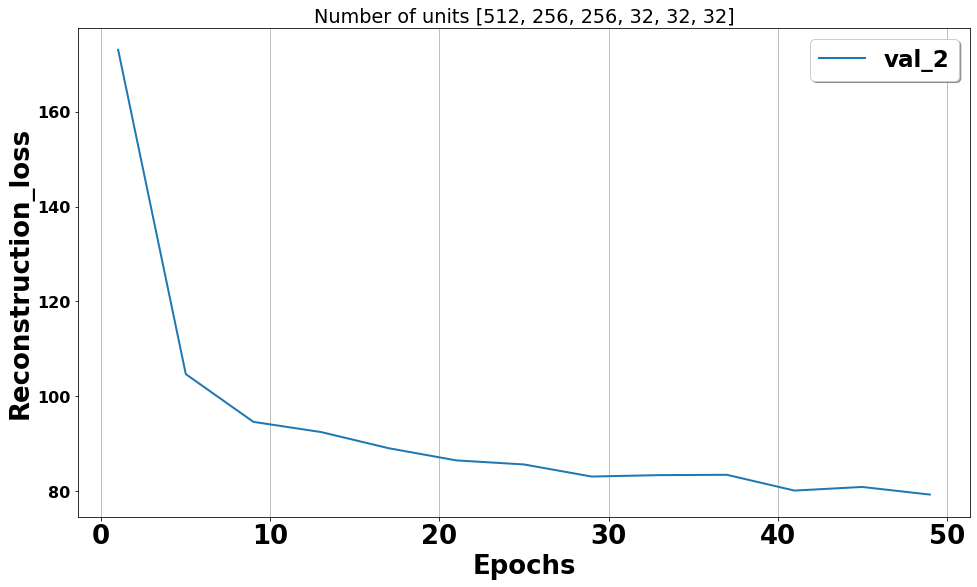

<Figure size 432x288 with 0 Axes>

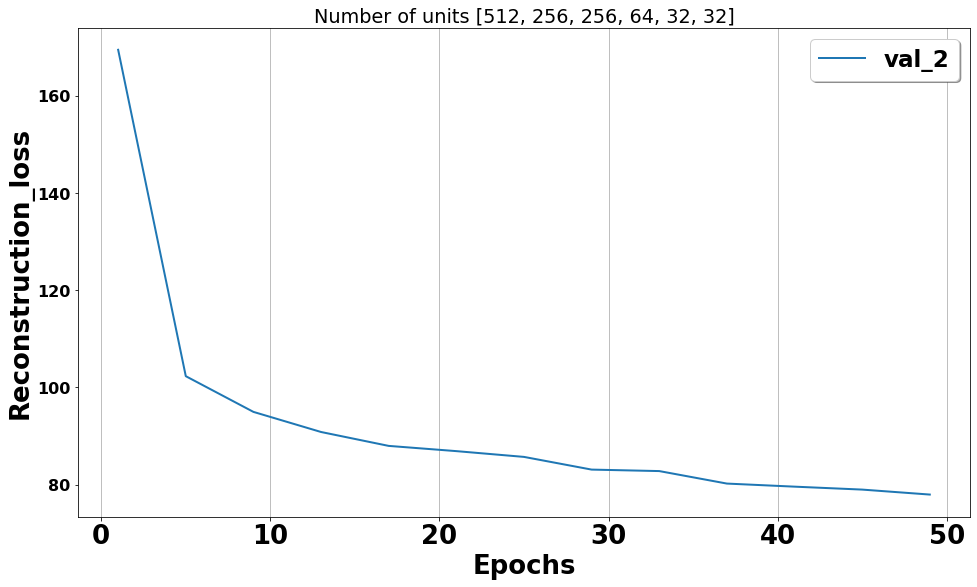

<Figure size 432x288 with 0 Axes>

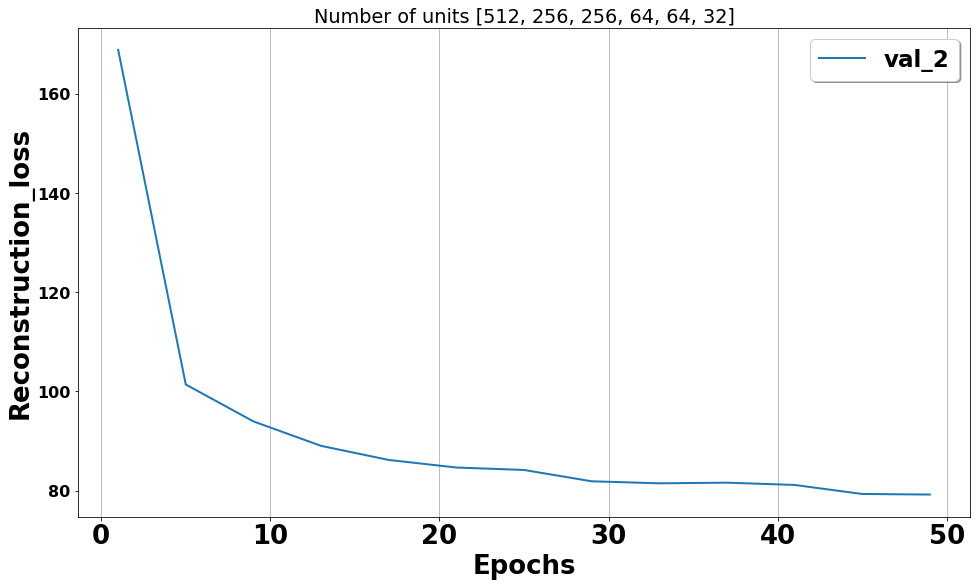

<Figure size 432x288 with 0 Axes>

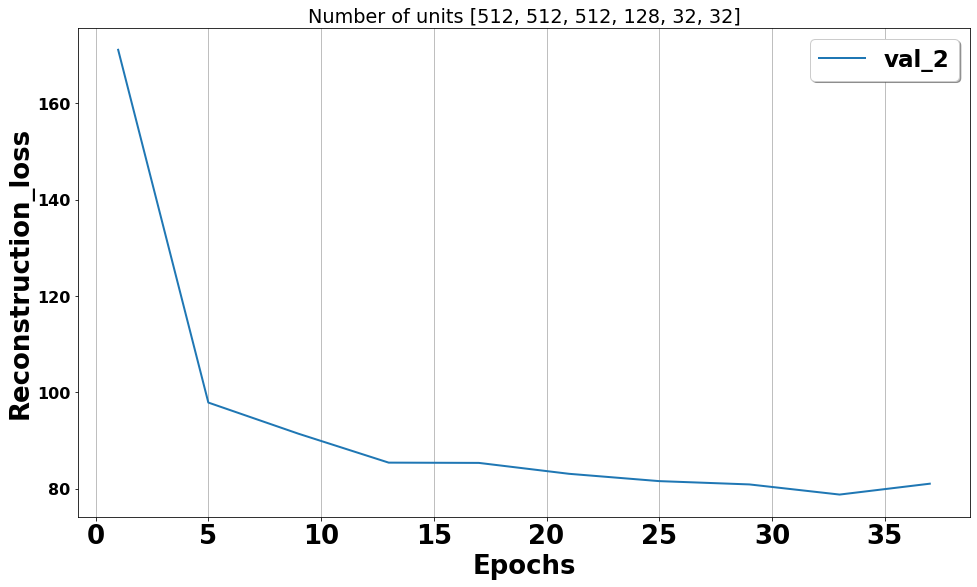

<Figure size 432x288 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

In [ ]:
run_id=2
dao = get_dao("mnist_concepts", "split_70_30", -1, dataset_path=root_path+"/datasets/",)
strides = stride_4_layer
for num_units in num_units_list_6layer_512_512_reversed[0:6]:
    print(num_units)
    exp_config = ExperimentConfig(root_path=root_path,
                                num_decoder_layer=5,
                                z_dim=z_dim,
                                num_units=num_units,
                                confidence_decay_factor=5,
                                beta=5,
                                supervise_weight=1,
                                dataset_name="mnist_concepts",
                                split_name="split_70_30",
                                model_name="VAE",
                                batch_size=512,
                                name=experiment_name,
                                num_val_samples=-1,
                                total_training_samples=dao.number_of_training_samples,
                                manual_labels_config=ExperimentConfig.USE_CLUSTER_CENTER,
                                reconstruction_weight=1,
                                activation_hidden_layer="RELU",
                                activation_output_layer="SIGMOID",
                                strides=strides,
                                num_dense_layers=0,
                                num_cluster_config=None
                                )
    plot_epoch_vs_accuracy(root_path=exp_config.root_path,
                            experiment_name=exp_config.name,
                            num_units=num_units,
                            z_dim=exp_config.Z_DIM,
                            run_ids=[run_id],
                            activation_output_layer="SIGMOID",
                            dataset_name=exp_config.dataset_name,
                            split_name=exp_config.split_name,
                            batch_size=exp_config.BATCH_SIZE,
                            num_val_samples=-exp_config.num_val_samples,
                            num_decoder_layer=exp_config.num_decoder_layer,
                            metric="reconstruction_loss",
                            strides=exp_config.strides,
                            num_dense_layers=exp_config.num_dense_layers,
                        num_cluster_config=exp_config.num_cluster_config,
                        dataset_types = ["val"],
                        exp_config=exp_config,
                        max_epoch=50
                        )
    plt.figure()

In [ ]:
# !rm -rf /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsupervised_vae_seg_mnist/Exp_32_256_512_512_512_512_16_2


In [ ]:
run_id=2
dao = get_dao("mnist_concepts", "split_70_30", -1, dataset_path=root_path+"/datasets/",)
strides = stride_4_layer
for num_units in num_units_list_6layer_512_512_reversed[0:6]:
    print(num_units)
    exp_config = ExperimentConfig(root_path=root_path,
                                num_decoder_layer=5,
                                z_dim=z_dim,
                                num_units=num_units,
                                confidence_decay_factor=5,
                                beta=5,
                                supervise_weight=1,
                                dataset_name="mnist_concepts",
                                split_name="split_70_30",
                                model_name="VAE",
                                batch_size=512,
                                name=experiment_name,
                                num_val_samples=-1,
                                total_training_samples=dao.number_of_training_samples,
                                manual_labels_config=ExperimentConfig.USE_CLUSTER_CENTER,
                                reconstruction_weight=1,
                                activation_hidden_layer="RELU",
                                activation_output_layer="SIGMOID",
                                strides=strides,
                                num_dense_layers=0,
                                num_cluster_config=None
                                )
    plot_epoch_vs_accuracy(root_path=exp_config.root_path,
                            experiment_name=exp_config.name,
                            num_units=num_units,
                            z_dim=exp_config.Z_DIM,
                            run_ids=[run_id],
                            activation_output_layer="SIGMOID",
                            dataset_name=exp_config.dataset_name,
                            split_name=exp_config.split_name,
                            batch_size=exp_config.BATCH_SIZE,
                            num_val_samples=-exp_config.num_val_samples,
                            num_decoder_layer=exp_config.num_decoder_layer,
                            metric="reconstruction_loss",
                            strides=exp_config.strides,
                            num_dense_layers=exp_config.num_dense_layers,
                        num_cluster_config=exp_config.num_cluster_config,
                        dataset_types = ["val"],
                        exp_config=exp_config,
                        max_epoch=50
                        )
    plt.figure()

In [ ]:
num_units_list_6layer_512_512_reversed

[[512, 256, 256, 32, 32, 32],
 [512, 256, 256, 64, 32, 32],
 [512, 256, 256, 64, 64, 32],
 [512, 512, 512, 128, 32, 32],
 [512, 512, 512, 128, 64, 32],
 [512, 512, 512, 256, 32, 32],
 [512, 512, 512, 256, 64, 32],
 [512, 512, 512, 256, 128, 32],
 [512, 512, 512, 256, 256, 32],
 [512, 512, 512, 512, 32, 32],
 [512, 512, 512, 512, 64, 32],
 [512, 512, 512, 512, 128, 32],
 [512, 512, 512, 512, 256, 32],
 [512, 512, 512, 512, 512, 32]]

In [ ]:
run_id=2
dao = get_dao("mnist_concepts", "split_70_30", -1, dataset_path=root_path+"/datasets/",)
strides = stride_4_layer
for num_units in num_units_list_5layer_512_256[0:7]:
    print(num_units)
    exp_config = ExperimentConfig(root_path=root_path,
                                num_decoder_layer=5,
                                z_dim=z_dim,
                                num_units=num_units,
                                confidence_decay_factor=5,
                                beta=5,
                                supervise_weight=1,
                                dataset_name="mnist_concepts",
                                split_name="split_70_30",
                                model_name="VAE",
                                batch_size=512,
                                name=experiment_name,
                                num_val_samples=-1,
                                total_training_samples=dao.number_of_training_samples,
                                manual_labels_config=ExperimentConfig.USE_CLUSTER_CENTER,
                                reconstruction_weight=1,
                                activation_hidden_layer="RELU",
                                activation_output_layer="SIGMOID",
                                strides=strides,
                                num_dense_layers=0,
                                num_cluster_config=None
                                )
    plot_epoch_vs_accuracy(root_path=exp_config.root_path,
                            experiment_name=exp_config.name,
                            num_units=num_units,
                            z_dim=exp_config.Z_DIM,
                            run_ids=[run_id],
                            activation_output_layer="SIGMOID",
                            dataset_name=exp_config.dataset_name,
                            split_name=exp_config.split_name,
                            batch_size=exp_config.BATCH_SIZE,
                            num_val_samples=-exp_config.num_val_samples,
                            num_decoder_layer=exp_config.num_decoder_layer,
                            metric="reconstruction_loss",
                            strides=exp_config.strides,
                            num_dense_layers=exp_config.num_dense_layers,
                        num_cluster_config=exp_config.num_cluster_config,
                        dataset_types = ["test"],
                        exp_config=exp_config,
                        max_epoch=50
                        )
    plt.figure()

# Scatter plot 4 layer

In [ ]:
plot_hidden_units_accuracy_layerwise(root_path=exp_config.root_path,
                                     experiment_name= exp_config.name,
                                     num_units= num_units_list_4layer_512,
                                         num_cluster_config=exp_config.num_cluster_config,
                                         z_dim=exp_config.Z_DIM,
                                         run_id=2,
                                         strides=num_units_list_4layer_512,
                                         num_dense_layers=0,
                                         dataset_types =["val"],
                                         dataset="mnist_concepts",
                                         split_name="split_70_30",
                                         batch_size=512,
                                         num_val_samples=-1,
                                         num_decoder_layer=4,
                                         layer_num=0,
                                         fixed_layers=[],
                                         metric="reconstruction_loss",
                                         cumulative_function="min",
                                         fig_size=(20,8),
                                         fname=None,
                                         legend_lc="best"
                                         )

dataset_name mnist_concepts
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/ split_70_30 manually_generated_concepts.json
Reading concepts map from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets//mnist_concepts/split_70_30/manually_generated_concepts.json
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
val [512, 256, 256, 128]
dataset_name mnist_concepts
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/ split_70_30 manually_generated_concepts.json
Reading concepts map from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets//mnist_concepts/split_70_30/manually_generated_concepts.json
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsupervised_vae_seg_mnist/Exp_128_256_256_512_16_2/analysis//reconstruction_loss*.csv
/content/gdrive

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


{512: [[640, 79.64202880859375, 13],
  [448, 80.9091567993164, 12],
  [384, 82.27546691894531, 12],
  [256, 83.3621826171875, 13],
  [224, 84.0014419555664, 12],
  [192, 85.95996856689453, 13],
  [128, 89.06570434570312, 13],
  [96, 107.75005340576172, 2]]}

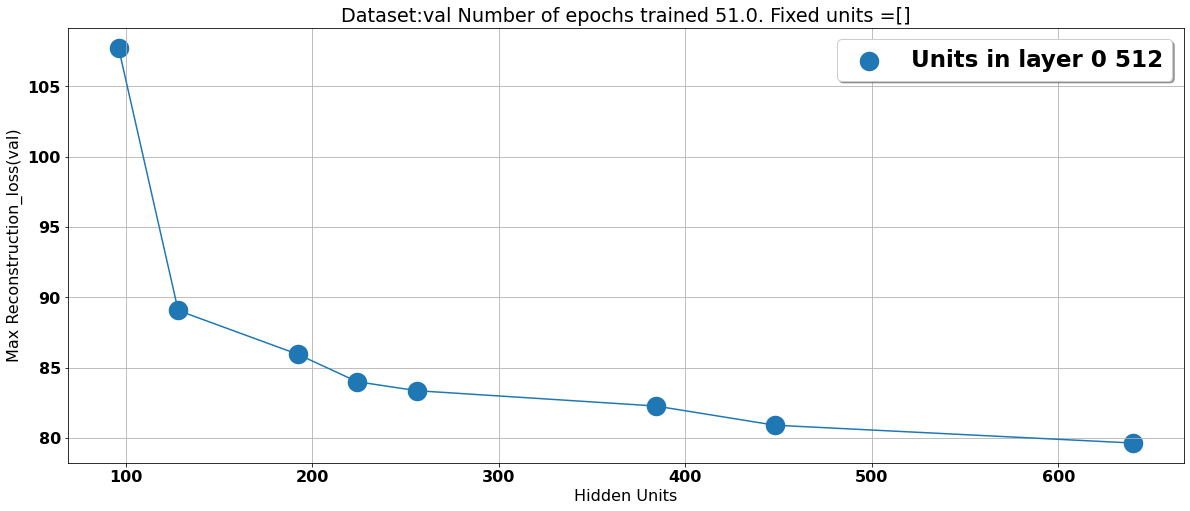

In [ ]:
plot_hidden_units_accuracy_layerwise(root_path=exp_config.root_path,
                                     experiment_name= exp_config.name,
                                     num_units= num_units_list_4layer_512,
                                         num_cluster_config=exp_config.num_cluster_config,
                                         z_dim=exp_config.Z_DIM,
                                         run_id=2,
                                         strides=num_units_list_4layer_512,
                                         num_dense_layers=0,
                                         dataset_types =["val"],
                                         dataset="mnist_concepts",
                                         split_name="split_70_30",
                                         batch_size=512,
                                         num_val_samples=-1,
                                         num_decoder_layer=4,
                                         layer_num=0,
                                         fixed_layers=[],
                                         metric="reconstruction_loss",
                                         cumulative_function="min",
                                         fig_size=(20,8),
                                         fname=None,
                                         legend_lc="best"
                                         )

mnist_concepts
dataset_name mnist_concepts
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/ split_70_30 manually_generated_concepts.json
Reading concepts map from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets//mnist_concepts/split_70_30/manually_generated_concepts.json
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
val [512, 256, 256, 128]
dataset_name val
dataset_name mnist_concepts
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/ split_70_30 manually_generated_concepts.json
Reading concepts map from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets//mnist_concepts/split_70_30/manually_generated_concepts.json
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_supervised_vae_seg_mnist/Exp_128_256_256_512_16_2/analysis//reconstruc

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

{128: [[128, 83.3621826171875, 13], [96, 84.0014419555664, 12]],
 256: [[384, 79.64202880859375, 13],
  [192, 80.9091567993164, 12],
  [128, 82.27546691894531, 12]]}

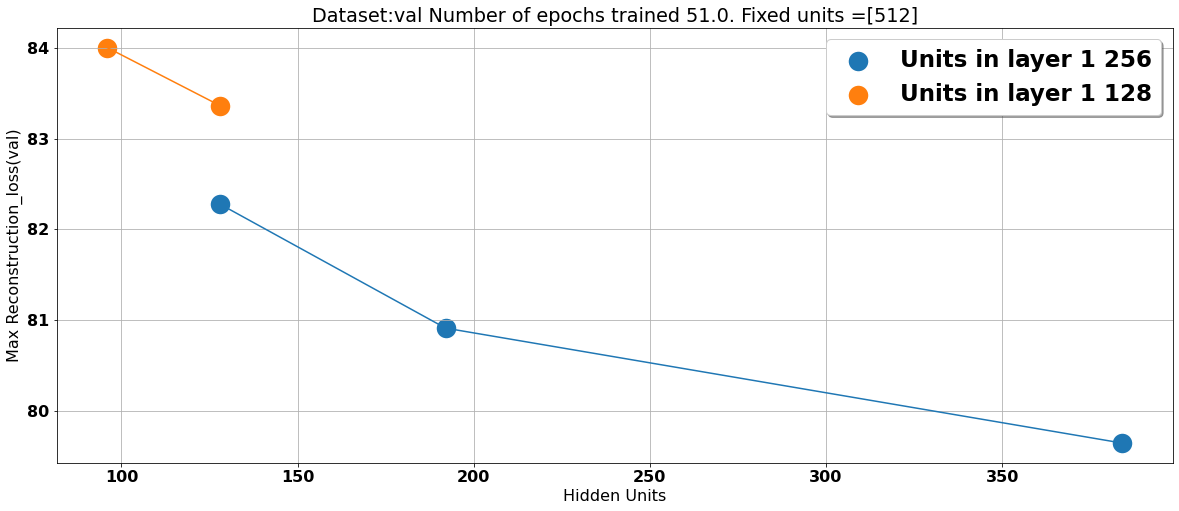

In [ ]:
plot_hidden_units_accuracy_layerwise(root_path=exp_config.root_path,
                                         experiment_name= exp_config.name,
                                         num_units= num_units_list_4layer_512[0:5],
                                         num_cluster_config=exp_config.num_cluster_config,
                                         z_dim=exp_config.Z_DIM,
                                         run_id=2,
                                         strides=num_units_list_4layer_512,
                                         num_dense_layers=0,
                                         dataset_types =["val"],
                                         dataset="mnist_concepts",
                                         split_name="split_70_30",
                                         batch_size=512,
                                         num_val_samples=-1,
                                         num_decoder_layer=4,
                                         layer_num=1,
                                         fixed_layers=[512],
                                         metric="reconstruction_loss",
                                         cumulative_function="min",
                                         fig_size=(20,8),
                                         fname=None,
                                         legend_lc="best"
                                         )

Inside function 2 /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_supervised_vae_seg_mnist/Exp_128_256_256_512_16_2/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_supervised_vae_seg_mnist/Exp_128_256_256_512_16_2/analysis//accuracy_*.csv
Reading from metrics.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_supervised_vae_seg_mnist/Exp_128_256_256_512_16_2/analysis//metrics_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_supervised_vae_seg_mnist/Exp_128_256_256_512_16_2/analysis//metrics_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_supervised_vae_seg_mnist/Exp_128_256_256_512_16_2/analysis/metrics_0.csv
Plotting completed


<Figure size 432x288 with 0 Axes>

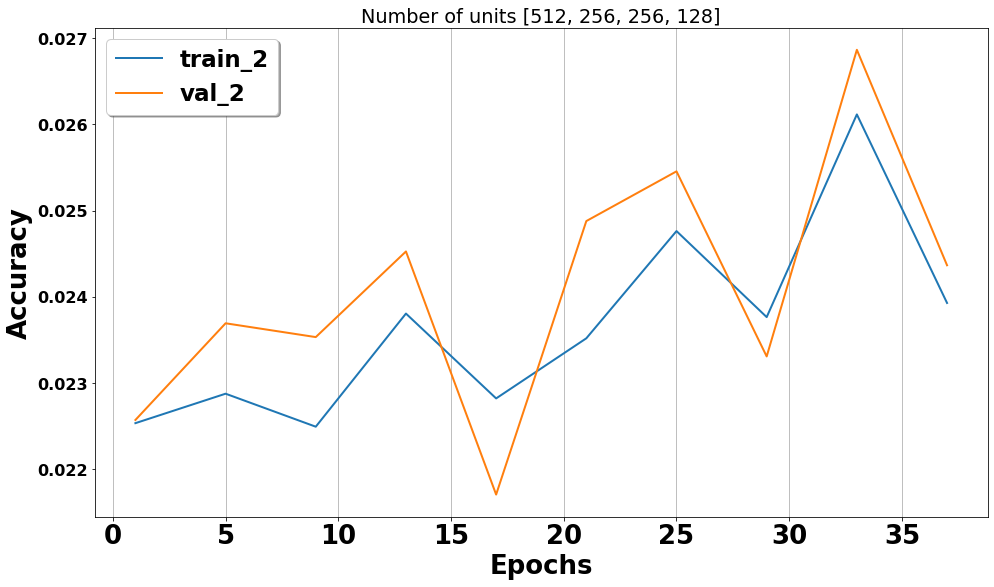

<Figure size 432x288 with 0 Axes>

In [ ]:
run_id=2
plot_epoch_vs_accuracy(root_path=exp_config.root_path,
                        experiment_name=exp_config.name,
                        num_units=exp_config.num_units,
                        z_dim=exp_config.Z_DIM,
                        run_ids=[run_id],
                        activation_output_layer="SIGMOID",
                        dataset_name=exp_config.dataset_name,
                        split_name=exp_config.split_name,
                        batch_size=exp_config.BATCH_SIZE,
                        num_val_samples=-exp_config.num_val_samples,
                        num_decoder_layer=exp_config.num_decoder_layer,
                        metric="accuracy",
                        strides=exp_config.strides,
                        num_dense_layers=exp_config.num_dense_layers,
                       num_cluster_config=exp_config.num_cluster_config,
                       dataset_types = ["train","val"],
                       exp_config=exp_config,
                       max_epoch=41
                      )
plt.figure()

In [ ]:
!ls /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_supervised_vae_seg_mnist/Exp_128_256_256_512_16_5/an

ls: cannot access '/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_supervised_vae_seg_mnist/Exp_128_256_256_512_16_5/an': No such file or directory


In [ ]:
num_units_list_5layer_512 = [[512, 256, 256, 128, 64],
                             [512, 256, 256, 128, 32],
                             [512, 256, 256, 64, 64],
                             [512, 256, 256, 64, 32]
                             ]


In [ ]:
exp_config = ExperimentConfig(root_path=root_path,
                              num_decoder_layer=4,
                              num_cluster_config=None,
                                                                                           name=experiment_name,
                                                                                           z_dim=z_dim,
                                                                                           batch_size=512,
                                                                                           beta=5,
                                                                                            reconstruction_weight=1,
                                                                                            num_units=num_units_list_5layer_512[0],
                                                                                            save_reconstructed_images=True,
                                                                                            split_name="split_70_30",
                                                                                           dataset_name="mnist_concepts",
                                                                                            eval_interval_in_epochs=4,
                                                                                            model_save_interval=10,
                                                                                            num_val_samples=-1,
                                                                                            run_evaluation_during_training=True,
                                                                                            return_latent_vector=False,
                                                                                            write_predictions=True,
                                                                                           fully_convolutional = True,
                                                                                           num_concepts=28,
                                                                                           strides=[2, 1, 2, 1, 2,1 ],
                                                                                           activation_output_layer = "SIGMOID",
                                                                                           num_dense_layers=0,
                                                                                           uncorrelated_features=False,
                              concept_id=17
                                                                                            )
exp_config.check_and_create_directories(run_id)


/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/ split_70_30 manually_generated_concepts.json
Reading concepts map from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets//mnist_concepts/split_70_30/manually_generated_concepts.json
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


True

Inside function 2 /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsupervised_vae_seg_mnist/Exp_128_256_256_512_16_2/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsupervised_vae_seg_mnist/Exp_128_256_256_512_16_2/analysis//accuracy_*.csv
Reading from metrics.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsupervised_vae_seg_mnist/Exp_128_256_256_512_16_2/analysis//metrics_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsupervised_vae_seg_mnist/Exp_128_256_256_512_16_2/analysis//metrics_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsupervised_vae_seg_mnist/Exp_128_256_256_512_16_2/analysis/metrics_0.csv
Plotting completed


<Figure size 432x288 with 0 Axes>

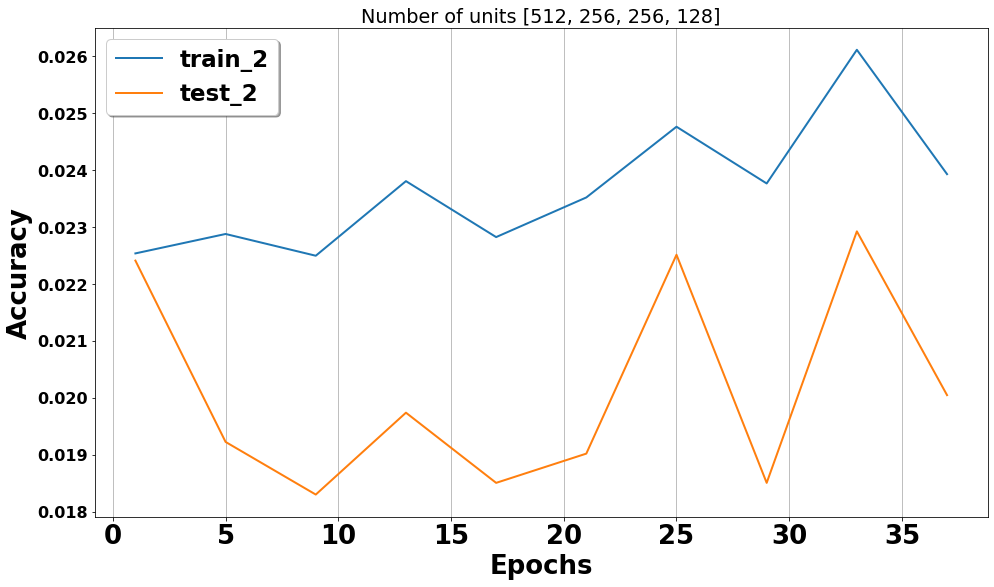

<Figure size 432x288 with 0 Axes>

In [ ]:
run_id=2
plot_epoch_vs_accuracy(root_path=exp_config.root_path,
                        experiment_name=exp_config.name,
                        num_units=exp_config.num_units,
                        z_dim=exp_config.Z_DIM,
                        run_ids=[run_id],
                        activation_output_layer="SIGMOID",
                        dataset_name=exp_config.dataset_name,
                        split_name=exp_config.split_name,
                        batch_size=exp_config.BATCH_SIZE,
                        num_val_samples=-exp_config.num_val_samples,
                        num_decoder_layer=exp_config.num_decoder_layer,
                        metric="accuracy",
                        strides=exp_config.strides,
                        num_dense_layers=exp_config.num_dense_layers,
                       num_cluster_config=exp_config.num_cluster_config,
                       dataset_types = ["train","test"],
                       exp_config=exp_config,
                       max_epoch=41
                      )
plt.figure()

In [ ]:
!ls /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_supervised_vae_seg_mnist/Exp_64_128_256_256_512_16_2/analysis/


manual_annotation.csv		z_train_128_64_16_epoch_5.csv
z_test_128_64_16_epoch_13.csv	z_train_128_64_16_epoch_9.csv
z_test_128_64_16_epoch_1.csv	z_val_128_64_16_epoch_13.csv
z_test_128_64_16_epoch_5.csv	z_val_128_64_16_epoch_1.csv
z_test_128_64_16_epoch_9.csv	z_val_128_64_16_epoch_5.csv
z_train_128_64_16_epoch_13.csv	z_val_128_64_16_epoch_9.csv
z_train_128_64_16_epoch_1.csv


In [ ]:
exp_config.dao.label_key_to_label_map[]

{'2_0_28_15_28': 25,
 '2_0_28_3_15': 24,
 '3_0_28_16_28': 23,
 '3_0_28_5_16': 22,
 '4_0_28_5_17': 20,
 '4_17_23_17_28': 21,
 '5_0_28_11_28': 19,
 '5_0_28_5_11': 18,
 '6_0_28_0_12': 16,
 '6_0_28_12_28': 17,
 '7_0_28_0_12': 14,
 '7_0_28_12_28': 15,
 '8_0_15_0_28': 11,
 '8_0_28_0_13': 13,
 '8_0_28_13_28': 12,
 '8_13_26_0_28': 10,
 '9_0_28_17_28': 27,
 '9_0_28_3_17': 26}

In [ ]:
exp_config